**Simulated Annealing for the predator-prey model**

In [94]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy.integrate import odeint


from scipy.optimize import minimize
import scipy.stats as stat

import ast
import csv

import warnings
# Ignore the ODEintWarning
warnings.filterwarnings("ignore", category=UserWarning, module="scipy.integrate._odepack")

In [3]:
# import data 
df = pd.read_csv("predator-prey-data.csv", delimiter = ",")
t = np.array(df["t"])
x = df["x"]
y = df["y"]

data = df

In [4]:
def lotka_volterra(init, t, alpha, beta, delta, gamma):
    x, y = init
    dxdt = alpha * x - beta * x * y 
    dydt = delta * x * y - gamma * y
    return dxdt, dydt

def abs_residual(params, data):
    x = np.array(data['x'],dtype=float)
    y = np.array(data['y'],dtype=float)
    x_and_y = np.vstack((x,y)).T

    t_data = np.array(data['t'],dtype=float)
    
    y0 = [x[0], y[0]]       
    model = odeint(lotka_volterra, y0, t_data, args=(params[0], params[1], params[2], params[3]))

    return np.linalg.norm(model - x_and_y)**2

def loss_function_res(params, data):
    x = np.array(data['x'],dtype=float)
    y = np.array(data['y'],dtype=float)
    t_data = np.array(data['t'],dtype=float)

    y0 = [x[0], y[0]]
    model = odeint(lotka_volterra, y0, t_data, args=(params[0], params[1], params[2], params[3]))

    loss = 0
    for i in range(len(t)):
        x_data = x[i]
        x_model = model[i,0]

        y_data = y[i]
        y_model = model[i,1]

        res = (x_data - x_model)**2 + (y_data - y_model)**2
        loss += res
    return loss

In [5]:
def simulated_annealing(init_guess, n_iterations, step, min_function, T_start, a, b, data):
    """"
    Performs simulated annealing to find global optimal values.
    init_guess = initial guess (array of real numbers, indicating alpha, beta, delta, gamma, x0 and y0)
    n_iterations = number of iterations to be performed
    std = standard deviation of the normal distribution that determines new possible solutions (step size)
    min_function = objective function (to be minimized)
    T_start = starting temperature for the cooling schedule
    a, b = variables for the cooling schedule
    data = the data to be fitted

    Returns the final solution and the fitness value of that solution
    """

    prev_sol = init_guess
    T = T_start
    
    for n in range(n_iterations):
        # create a new solution
        new_sol = prev_sol + np.random.normal(0, step, size=len(prev_sol))

        # determine whether new_sol is accepted 
        u = np.random.uniform()

        fit_new_sol = min_function(new_sol,data)
        fit_prev_sol = min_function(prev_sol,data)

        # use Boltzman distribution
        if u < min(np.exp((-fit_new_sol + fit_prev_sol)/T),1): 
            prev_sol = new_sol
        
        # decrease the temperature
        n += 1
        T = a/np.log(n + b)

    return prev_sol, min_function(prev_sol,data)

In [6]:
def plot_fit(params, df):
    alpha = params[0]
    beta = params[1]
    delta = params[2]
    gamma = params[3]

    y0 = [x[0], y[0]]
     
    time = np.array(df['t'])
    t = np.linspace(time[0], time[-1], 1000)

    output = odeint(lotka_volterra, y0, t, args=(alpha, beta, delta, gamma))

    # Prey population separate
    plt.plot(t,output[:,0], color="r", label = 'Prey')
    plt.scatter(df["t"], df["x"], color = 'r', s = 5)

    plt.legend(fontsize = 15, loc = 'upper right')
    plt.ylabel("Population size", fontsize = 15)
    plt.xlabel("Time", fontsize = 15)
    plt.tick_params(labelsize=15)
    plt.grid()

    plt.show()

    # Predator population separate
    plt.plot(t,output[:,1], color="b", label = 'Predator')
    plt.scatter(df["t"], df["y"], color = 'b', s = 5)

    plt.legend(fontsize = 15, loc = 'upper right')
    plt.ylabel("Population size", fontsize = 15)
    plt.xlabel("Time", fontsize = 15)
    plt.tick_params(labelsize=15)
    plt.grid()

    plt.show()

    # Both populations together

    plt.plot(t,output[:,0], color="r")
    plt.scatter(df["t"], df["x"], color = 'r', s = 5, label = 'Prey')
    plt.plot(t,output[:,1], color="b")
    plt.scatter(df["t"], df["y"], color = 'b', s = 5, label = 'Predator')
    
    plt.legend(fontsize = 15)
    plt.ylabel("Population size", fontsize = 15)
    plt.xlabel("Time", fontsize = 15)
    plt.tick_params(labelsize=15)
    plt.grid()

    plt.show()


In [18]:
np.random.seed(5)

init_guess = np.random.uniform(-1,1,4)
n_iterations = 13000
std = 0.5
min_function = abs_residual
T_start = 20
a = 3
b = 10

params, err = simulated_annealing(init_guess, n_iterations, std, min_function, T_start, a, b, data)

C:\Users\Esthe\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\scipy\integrate\_odepack_py.py:248: ODEintWarning: Excess work done on this call (perhaps wrong Dfun type). Run with full_output = 1 to get quantitative information.
  warnings.warn(warning_msg, ODEintWarning)
C:\Users\Esthe\AppData\Local\Temp\ipykernel_19972\3829339896.py:29: RuntimeWarning: overflow encountered in exp
  if u < min(np.exp((-fit_new_sol + fit_prev_sol)/T),1):


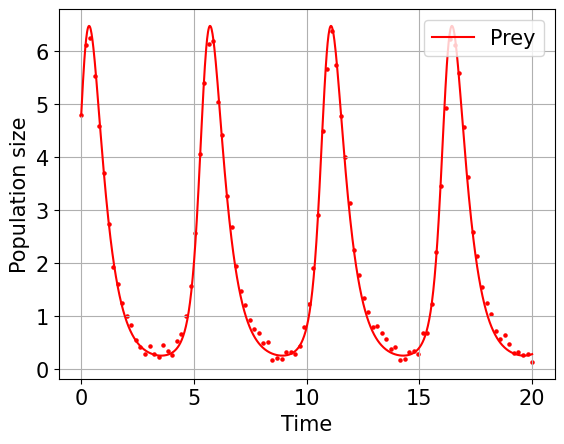

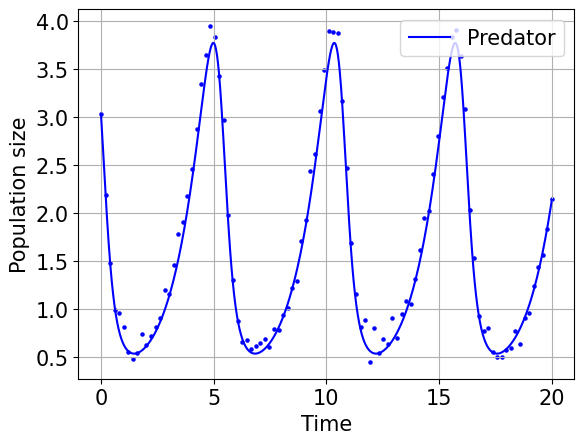

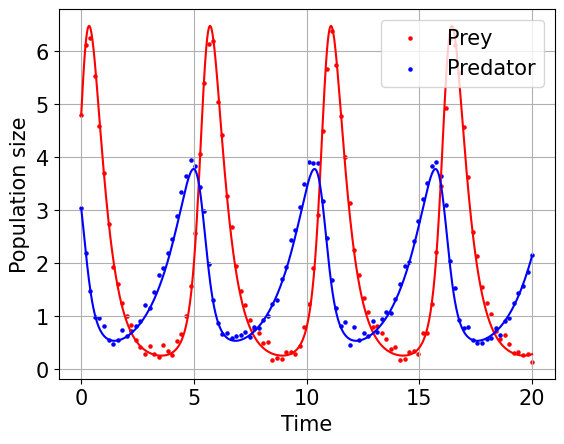

In [19]:
plot_fit(params, df)

**Tuning**

In [7]:
def multi_runs(runs, init_guess, n_iterations, step, min_function, T_start, a, b, data):
    """
    Runs the simulated annealing algorithm multiple times, with random initial guess.
    Returns:
    err_temp = list of all errors (determined with min_function)
    best_sol = solution with lowest residual over all runs
    err_best = residual of best solution
    """
    err_temp = []
    for _ in range(runs):
        init_guess = np.random.uniform(0,1,4)
        params, err = simulated_annealing(init_guess, n_iterations, step, min_function, T_start, a, b, data)
        err_temp.append(err)

        if err < float('inf'):
            best_sol = params
            err_best = err
    return err_temp, best_sol, err_best

In [9]:
# Parameter tuning for step size

n_iterations = 1300
min_function = loss_function_res
T_start = 2
a = 3
b = 10
data = df

step_range = np.arange(0.1,2,0.2)
runs = 30

err_list = []
std_list = []
best_err_so_far = float('inf')

for step in step_range:
    print(step)

    err_temp, best_sol, err_best = multi_runs(runs, init_guess, n_iterations, step, min_function, T_start, a, b, data)

    # save overall best solution and its step size
    if err_best < best_err_so_far:
        best_err_so_far = err_best
        best_sol_total = best_sol
        best_step = step

    err_list.append(np.mean(err_temp))
    std_list.append(np.std(err_temp))

0.1


/var/folders/wr/_f23fm512gg3qhxthyg30lvc0000gn/T/ipykernel_3802/3829339896.py:29: RuntimeWarning: overflow encountered in exp
  if u < min(np.exp((-fit_new_sol + fit_prev_sol)/T),1):


 lsoda--  warning..internal t (=r1) and h (=r2) are  
       such that in the machine, t + h = t on the next step  
       (h = step size). solver will continue anyway  
      in above,  r1 =  0.1700092158579D+02   r2 =  0.1424775450140D-14
 lsoda--  warning..internal t (=r1) and h (=r2) are  
       such that in the machine, t + h = t on the next step  
       (h = step size). solver will continue anyway  
      in above,  r1 =  0.1700092158579D+02   r2 =  0.1424775450140D-14
 lsoda--  warning..internal t (=r1) and h (=r2) are  
       such that in the machine, t + h = t on the next step  
       (h = step size). solver will continue anyway  
      in above,  r1 =  0.1700092158579D+02   r2 =  0.1179689266331D-14
 lsoda--  warning..internal t (=r1) and h (=r2) are  
       such that in the machine, t + h = t on the next step  
       (h = step size). solver will continue anyway  
      in above,  r1 =  0.1700092158579D+02   r2 =  0.1179689266331D-14
 lsoda--  warning..internal t (=r1) 

/var/folders/wr/_f23fm512gg3qhxthyg30lvc0000gn/T/ipykernel_3802/3544330308.py:37: RuntimeWarning: overflow encountered in scalar power
  res = (x_data - x_model)**2 + (y_data - y_model)**2


 lsoda--  warning..internal t (=r1) and h (=r2) are  
       such that in the machine, t + h = t on the next step  
       (h = step size). solver will continue anyway  
      in above,  r1 =  0.1015851522913D+02   r2 =  0.7355746303609D-15
 lsoda--  warning..internal t (=r1) and h (=r2) are  
       such that in the machine, t + h = t on the next step  
       (h = step size). solver will continue anyway  
      in above,  r1 =  0.1015851522913D+02   r2 =  0.7355746303609D-15
 lsoda--  warning..internal t (=r1) and h (=r2) are  
       such that in the machine, t + h = t on the next step  
       (h = step size). solver will continue anyway  
      in above,  r1 =  0.1015851522913D+02   r2 =  0.7355746303609D-15
 lsoda--  warning..internal t (=r1) and h (=r2) are  
       such that in the machine, t + h = t on the next step  
       (h = step size). solver will continue anyway  
      in above,  r1 =  0.1015851522913D+02   r2 =  0.7355746303609D-15
 lsoda--  warning..internal t (=r1) 

In [10]:
print(f"best parameter values found during tuning: {best_sol_total}")
print(f"minimal error value: {best_err_so_far} with step size {best_step}")

best parameter values found during tuning: [-1.16180766 -0.84126499 -0.74661181 -1.57834783]
minimal error value: 33.60679365465331 with step size 1.1000000000000003


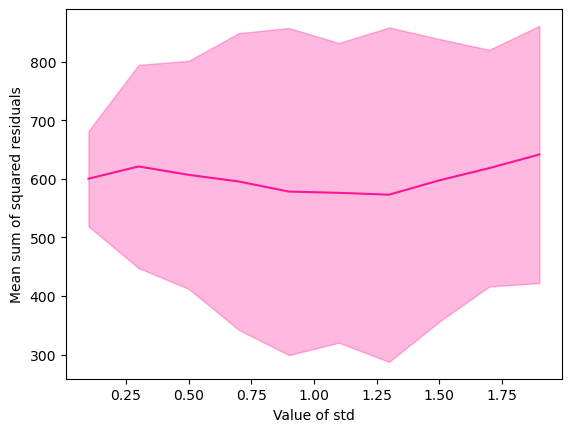

In [11]:
plt.plot(step_range, err_list, color = 'deeppink')
plt.fill_between(step_range, np.array(err_list)-np.array(std_list), np.array(err_list)+np.array(std_list), color = 'deeppink', alpha = 0.3)
plt.xlabel('Value of std')
plt.ylabel('Mean sum of squared residuals')
plt.show()

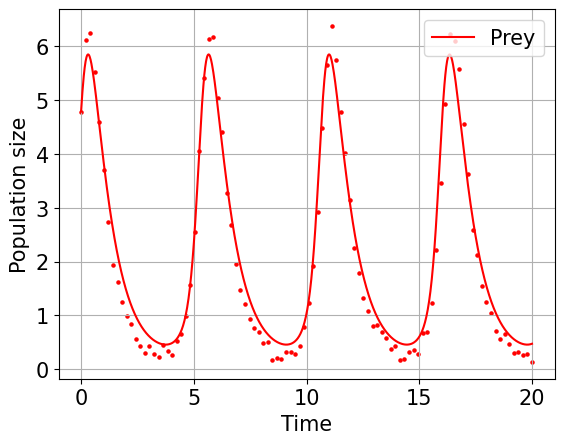

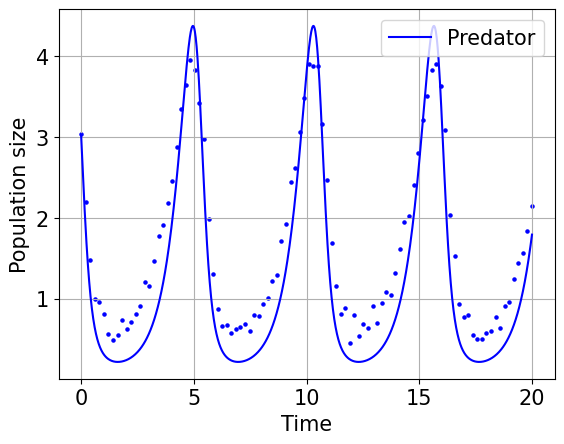

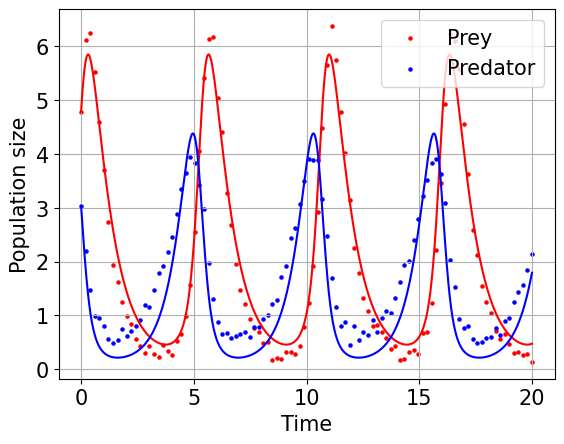

In [20]:
# Plot the best solution

plot_fit(best_sol_total,data)

**3D plot with the amount of runs vs. step size**

**Stochastic hill climbing**

Chooses at random from uphill moves (steepness determines probability of selection)

In [7]:
def stoch_hill_climb(init_guess, std, min_function, data, n_iterations):
    prev_sol = init_guess

    for _ in range(n_iterations):
        # create a new solution
        new_sol = []
        for param in prev_sol:
            new_param = param + np.random.normal(0,std)
            new_sol.append(new_param)

        # determine whether new_sol is accepted
        u = np.random.uniform()
        if u < np.exp(min_function(new_sol,data))/np.exp(min_function(prev_sol,data)):
            prev_sol = new_sol

    return prev_sol

In [99]:
init_guess = np.ones(4)
std = 0.1
min_function = abs_residual
data = df
n_iterations = 10000

params_shc = stoch_hill_climb(init_guess,std,min_function,data,n_iterations)

/var/folders/wr/_f23fm512gg3qhxthyg30lvc0000gn/T/ipykernel_54516/2068039739.py:13: RuntimeWarning: overflow encountered in exp
  if u < np.exp(min_function(new_sol,data))/np.exp(min_function(prev_sol,data)):
/var/folders/wr/_f23fm512gg3qhxthyg30lvc0000gn/T/ipykernel_54516/2068039739.py:13: RuntimeWarning: invalid value encountered in scalar divide
  if u < np.exp(min_function(new_sol,data))/np.exp(min_function(prev_sol,data)):


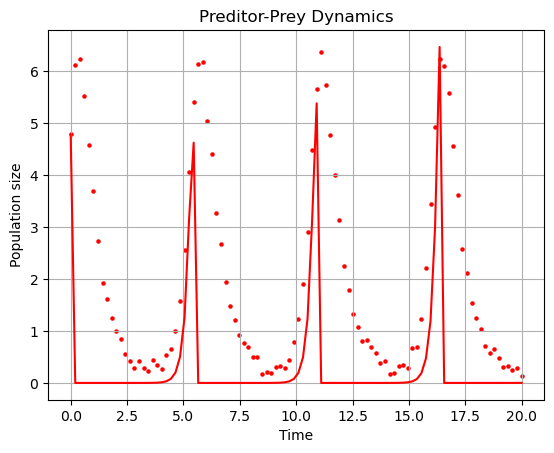

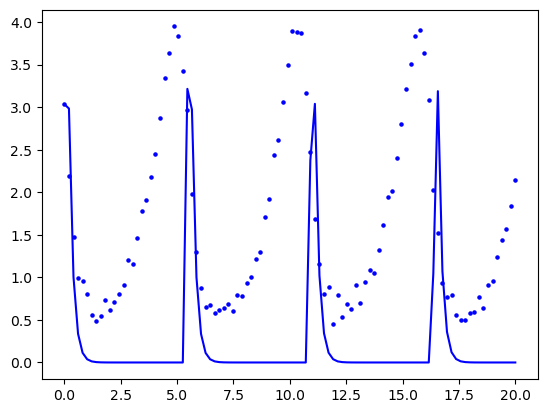

In [100]:
alpha_shc = params_shc[0]
beta_shc = params_shc[1]
delta_shc = params_shc[2]
gamma_shc = params_shc[3]

y0 = [x[0], y[0]]
t = np.linspace(t[0], t[-1], num=len(t))

output_shc = odeint(lotka_volterra, y0, t, args=(alpha_shc, beta_shc, delta_shc, gamma_shc))

plt.title("Preditor-Prey Dynamics")
plt.ylabel("Population size")
plt.xlabel("Time")
plt.grid()

plt.plot(t,output[:,0], color="r")
plt.scatter(df["t"], df["x"], color = 'r', s = 5, label = 'x (prey)')

plt.show()

plt.plot(t,output[:,1], color="b")
plt.scatter(df["t"], df["y"], color = 'b', s = 5, label = 'x (predator)')

plt.show()

## Time series

subsets: 
1. percentage removed: 0, 10, 20, 30, 40, 50, 60.

2. subsets together: 60 + 40

3. last percentage removed: last 20, 50.

4. peaks predators, peaks prey. (Try to make it 20, 50 points)


### functions

In [85]:
from scipy.optimize import minimize
# Objective functions

def abs_residual(params, data):
    x = np.array(data['x'],dtype=float)
    y = np.array(data['y'],dtype=float)
    x_and_y = np.vstack((x,y)).T

    t_data = np.array(data['t'],dtype=float)
    
    y0 = [x[0], y[0]]       
    model = odeint(lotka_volterra, y0, t_data, args=(params[0], params[1], params[2], params[3]))

    return np.linalg.norm(model - x_and_y)**2

def loss_function_res(params, data):
    x = np.array(data['x'],dtype=float)
    y = np.array(data['y'],dtype=float)
    t_data = np.array(data['t'],dtype=float)

    y0 = [x[0], y[0]]
    model = odeint(lotka_volterra, y0, t_data, args=(params[0], params[1], params[2], params[3]))

    loss = 0
    for i in range(len(t_data)):
        x_data = x[i]
        x_model = model[i,0]

        y_data = y[i]
        y_model = model[i,1]

        res = (x_data - x_model)**2 + (y_data - y_model)**2
        loss += res
    return loss

def minimise_loss_function_res(df, params0=None):
    if params0 is None:
        params0 = np.array([-1, -0.5, -0.5, -2])
    output_minimise = minimize(loss_function_res, params0, args=(df))
    # fitted_parameters = output_minimise.x
    # loss = output_minimise.fun
    return output_minimise

def plot_lotka(df, fitted_parameters, extra_df=None):
    t = np.array(df['t'], dtype=float)
    x = np.array(df['x'], dtype=float)
    y = np.array(df['y'], dtype=float)
    alpha_fit, beta_fit, delta_fit, gamma_fit = fitted_parameters
    y0 = [x[0], y[0]]
    t = np.linspace(t[0], t[-1], num=len(t))
    output = odeint(lotka_volterra, y0, t, args=(alpha_fit, beta_fit, delta_fit, gamma_fit))

    plt.title("Preditor-Prey Dynamics")
    plt.ylabel("Population size")
    plt.xlabel("Time")
    plt.grid()

    plt.plot(t,output[:,0], color="r")
    plt.scatter(df["t"], df["x"], color = 'r', s = 5, label = 'x (prey)')

    if extra_df is not None:
        plt.scatter(extra_df["t"], extra_df["x"], color = 'black', s = 5, label = 'x (prey)')

    plt.show()

    plt.plot(t,output[:,1], color="b")
    plt.scatter(df["t"], df["y"], color = 'b', s = 5, label = 'x (predator)')
    if extra_df is not None:
        plt.scatter(extra_df["t"], extra_df["y"], color = 'black', s = 5, label = 'x (prey)')

    plt.show()


# Time series
def remove_random_rows(df, percentage):
    '''
    Percentage as decimal number.
    '''
    # Number of rows to remove
    remove_n = int(len(df) * percentage)

    drop_indices = np.random.choice(df.index, remove_n, replace=False)
    return df.drop(drop_indices)

def remove_last(df, percentage):
    '''
    Percentage as decimal number.
    '''
    index_to_keep = int(len(df) * (1-percentage))
    return df.iloc[:index_to_keep]

def filter_df(df, column, lower, upper):
    return df[~df[column].between(lower, upper)]

# 1. Time Series Remove Rows
def multi_run_remove_rows(df, n_runs, objective_function='abs'):
    dict_percentage_loss = {}
    for percentage in range(0,62,10):
        temp_losses = []
        for run in range(n_runs):
            print(f'percentage: {percentage}: run {run}')
            # determine subset
            df_subset = remove_random_rows(df, percentage/100)

            init_guess = np.random.uniform(-1,1,4)
            n_iterations =  1000
            step = 1.1
            if objective_function == 'abs':
                min_function = abs_residual
            if objective_function == 'sum':
                min_function = loss_function_res

            T_start = 2
            a =  3
            b =  10
            params = simulated_annealing(init_guess, n_iterations, step, min_function, T_start, a, b, df_subset)[0]

            # calculate the loss for the parameters for the original data points
            if objective_function == 'abs':
                loss = abs_residual(params, df)
            if objective_function == 'sum':
                loss = loss_function_res(params, df)
            temp_losses.append(loss)
        dict_percentage_loss[percentage] = temp_losses
    return dict_percentage_loss

# 2. Combine time series
def multi_run_concat_40_60(df, n_runs, objective_function):
    losses = []
    for run in range(n_runs):
        print(f'run {run}')
        # determine subset
        df_subset_40 = remove_random_rows(df, 40/100)
        df_subset_60 = remove_random_rows(df, 60/100)
        df_subset = pd.concat([df_subset_40, df_subset_60], ignore_index=True).sort_values(by='t')

        # Get optimal parameters for this subset
        init_guess = np.random.uniform(-1,1,4)
        n_iterations =  1000
        step = 1.1
        if objective_function == 'abs':
            min_function = abs_residual
        if objective_function == 'sum':
            min_function = loss_function_res

        T_start = 2
        a =  3
        b =  10
        params = simulated_annealing(init_guess, n_iterations, step, min_function, T_start, a, b, df_subset)[0]

        # calculate the loss for the parameters for the original data points
        if objective_function == 'abs':
            loss = abs_residual(params, df)
        if objective_function == 'sum':
            loss = loss_function_res(params, df)
        losses.append(loss)
    return losses

# 3. Time Series Remove Last rows (20, 50)
def multi_run_remove_last_rows(df, n_runs, objective_function='abs'):
    dict_percentage_loss = {}
    for percentage in [20, 50]:
        temp_losses = []
        for run in range(n_runs):
            print(f'percentage: {percentage}: run {run}')
            # determine subset
            df_subset = remove_last(df, percentage/100)

            init_guess = np.random.uniform(-1,1,4)
            n_iterations =  1000
            step = 1.1
            if objective_function == 'abs':
                min_function = abs_residual
            if objective_function == 'sum':
                min_function = loss_function_res

            T_start = 2
            a =  3
            b =  10
            params = simulated_annealing(init_guess, n_iterations, step, min_function, T_start, a, b, df_subset)[0]

            # calculate the loss for the parameters for the original data points
            if objective_function == 'abs':
                loss = abs_residual(params, df)
            if objective_function == 'sum':
                loss = loss_function_res(params, df)
            temp_losses.append(loss)
        dict_percentage_loss[percentage] = temp_losses
    return dict_percentage_loss


# 4. predator peaks. (20, 50) removed. 50 and 80 length.
def multi_run_peaks(df, n_runs, objective_function='abs'):
    dict_percentage_loss = {}
    for percentage in [20, 50]:
        temp_losses = []
        for run in range(n_runs):
            print(f'percentage: {percentage}: run {run}')
            # determine subset
            df_subset = remove_last(df, percentage/100)

            if percentage == 20:
                df_subset = filter_df(df, 'x', 1.5, 4) # 80
            
            if percentage == 50:
                df_subset = filter_df(df, 'x', 0.68, 5) # 50

            init_guess = np.random.uniform(-1,1,4)
            n_iterations =  1000
            step = 1.1
            if objective_function == 'abs':
                min_function = abs_residual
            if objective_function == 'sum':
                min_function = loss_function_res

            T_start = 2
            a =  3
            b =  10
            params = simulated_annealing(init_guess, n_iterations, step, min_function, T_start, a, b, df_subset)[0]

            # calculate the loss for the parameters for the original data points
            if objective_function == 'abs':
                loss = abs_residual(params, df)
            if objective_function == 'sum':
                loss = loss_function_res(params, df)
            temp_losses.append(loss)
        dict_percentage_loss[percentage] = temp_losses
    return dict_percentage_loss

def plot_dict(dict, optimization, method):
    keys = np.array(list(dict.keys()))
    values = np.array(list(dict.values()))
    # means = np.mean(values, axis=1)
    # stds = np.std(values, axis=1)
    means = []
    lower = []
    upper = []

    for value in values:
        if isinstance(value, str):
            value = ast.literal_eval(value)
        mean = np.mean(value)
        ci =stat.t.interval(confidence=0.95, df=len(value)-1, loc=mean, scale=stat.sem(value))
        means.append(mean)
        lower.append(ci[0])
        upper.append(ci[1])

    plt.plot(keys, means)
    # plt.fill_between(keys, np.array(lower), np.array(upper), alpha=0.3)
    plt.yscale('log')
    plt.xlabel('Percentage Removed')
    plt.ylabel('Loss ' + optimization)
    plt.show()

    # Create a DataFrame
    data = {'Method': method, 'Optimization': optimization, 'Mean': means, 'Lower Bound': lower, 'Upper Bound': upper}
    df = pd.DataFrame(data, columns=['Method', 'Optimization', 'Mean', 'Lower Bound', 'Upper Bound'], index=keys)
    return df


def plot_box_dict(dict, optimization):
    keys = np.array(list(dict.keys()))
    values = list(dict.values())
    if isinstance(values[0], str):
        for i in range(len(values)):
            print(values[i])
            values[i] = ast.literal_eval(values[i])
    values = np.array(values)
    # Create a figure and axis
    fig, ax = plt.subplots()

    # Create boxplots for each list in the data
    ax.boxplot(values.T, showfliers=False)

    # Set x-axis labels
    ax.set_xticklabels(keys)
    # Set axis labels and title
    ax.set_xlabel('Percentage Removed')
    ax.set_ylabel('Loss ' + optimization)

    # Show the plot
    plt.show()




In [12]:
# Open the file in write mode
def save_dict(my_dict, file_name):
    with open(file_name, 'w', newline='') as csvfile:
        # Create a CSV writer
        csv_writer = csv.writer(csvfile)

        # Write the header (keys of the dictionary)
        csv_writer.writerow(my_dict.keys())

        # Write the values
        csv_writer.writerow(my_dict.values())

def open_dict(file_name):
    # Open the file in read mode
    with open(file_name, 'r') as csvfile:
        # Create a CSV reader
        csv_reader = csv.reader(csvfile)

        # Read the header (keys of the dictionary)
        header = next(csv_reader)

        # Read the values
        values = next(csv_reader)

    # Create a dictionary using the header and values
    return dict(zip(header, values))
   
# dict_abs = open_dict('dict_abs.csv') 
# dict_sum = open_dict('dict_sum.csv') 

# dict_abs_combine # beneden
# dict_sum_combine # beneden 

# dict_abs_specific = open_dict('dict_abs_specific.csv') 
# dict_sum_specific = open_dict('dict_sum_specific.csv') 

# dict_abs_peaks = open_dict('dict_abs_peaks.csv') 
# dict_sum_peaks = open_dict('dict_sum_peaks.csv') 


In [22]:
np.random.seed(3)
df = pd.read_csv("predator-prey-data.csv", delimiter = ",")

n_runs = 100

# dict_abs = multi_run_remove_rows(df, n_runs, objective_function='abs')
# save_dict(dict_abs, 'dict_abs.csv') 
# dict_sum = multi_run_remove_rows(df, n_runs, objective_function='sum')
# save_dict(dict_sum, 'dict_sum.csv') 

# dict_abs_combine = multi_run_concat_40_60(df, n_runs, objective_function='abs')
# # save_dict(dict_abs_combine, 'dict_abs_combine.csv') 
# dict_sum_combine = multi_run_concat_40_60(df, n_runs, objective_function='sum')
# save_dict(dict_sum_combine, 'dict_sum_combine.csv') 

# dict_abs_specific = multi_run_remove_last_rows(df, n_runs, objective_function='abs')
# save_dict(dict_abs_specific, 'dict_abs_specific.csv') 
# dict_sum_specific = multi_run_remove_last_rows(df, n_runs, objective_function='sum')
# save_dict(dict_sum_specific, 'dict_sum_specific.csv') 

# dict_abs_peaks = multi_run_peaks(df, n_runs, objective_function='abs')
# save_dict(dict_abs_peaks, 'dict_abs_peaks.csv') 
# dict_sum_peaks = multi_run_peaks(df, n_runs, objective_function='sum')
# save_dict(dict_sum_peaks, 'dict_sum_peaks.csv') 

run 0


C:\Users\Esthe\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\scipy\integrate\_odepack_py.py:248: ODEintWarning: Excess work done on this call (perhaps wrong Dfun type). Run with full_output = 1 to get quantitative information.
  warnings.warn(warning_msg, ODEintWarning)


run 1


C:\Users\Esthe\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\scipy\integrate\_odepack_py.py:248: ODEintWarning: Excess work done on this call (perhaps wrong Dfun type). Run with full_output = 1 to get quantitative information.
  warnings.warn(warning_msg, ODEintWarning)
C:\Users\Esthe\AppData\Local\Temp\ipykernel_18508\3829339896.py:29: RuntimeWarning: overflow encountered in exp
  if u < min(np.exp((-fit_new_sol + fit_prev_sol)/T),1):


run 2


C:\Users\Esthe\AppData\Local\Temp\ipykernel_18508\3829339896.py:29: RuntimeWarning: overflow encountered in exp
  if u < min(np.exp((-fit_new_sol + fit_prev_sol)/T),1):
C:\Users\Esthe\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\scipy\integrate\_odepack_py.py:248: ODEintWarning: Excess work done on this call (perhaps wrong Dfun type). Run with full_output = 1 to get quantitative information.
  warnings.warn(warning_msg, ODEintWarning)


run 3


C:\Users\Esthe\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\scipy\integrate\_odepack_py.py:248: ODEintWarning: Excess work done on this call (perhaps wrong Dfun type). Run with full_output = 1 to get quantitative information.
  warnings.warn(warning_msg, ODEintWarning)
C:\Users\Esthe\AppData\Local\Temp\ipykernel_18508\3829339896.py:29: RuntimeWarning: overflow encountered in exp
  if u < min(np.exp((-fit_new_sol + fit_prev_sol)/T),1):


run 4


C:\Users\Esthe\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\scipy\integrate\_odepack_py.py:248: ODEintWarning: Excess work done on this call (perhaps wrong Dfun type). Run with full_output = 1 to get quantitative information.
  warnings.warn(warning_msg, ODEintWarning)


run 5


C:\Users\Esthe\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\scipy\integrate\_odepack_py.py:248: ODEintWarning: Excess work done on this call (perhaps wrong Dfun type). Run with full_output = 1 to get quantitative information.
  warnings.warn(warning_msg, ODEintWarning)
C:\Users\Esthe\AppData\Local\Temp\ipykernel_18508\3829339896.py:29: RuntimeWarning: overflow encountered in exp
  if u < min(np.exp((-fit_new_sol + fit_prev_sol)/T),1):


run 6


C:\Users\Esthe\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\scipy\integrate\_odepack_py.py:248: ODEintWarning: Excess work done on this call (perhaps wrong Dfun type). Run with full_output = 1 to get quantitative information.
  warnings.warn(warning_msg, ODEintWarning)
C:\Users\Esthe\AppData\Local\Temp\ipykernel_18508\3829339896.py:29: RuntimeWarning: overflow encountered in exp
  if u < min(np.exp((-fit_new_sol + fit_prev_sol)/T),1):


run 7


C:\Users\Esthe\AppData\Local\Temp\ipykernel_18508\3829339896.py:29: RuntimeWarning: overflow encountered in exp
  if u < min(np.exp((-fit_new_sol + fit_prev_sol)/T),1):
C:\Users\Esthe\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\scipy\integrate\_odepack_py.py:248: ODEintWarning: Excess work done on this call (perhaps wrong Dfun type). Run with full_output = 1 to get quantitative information.
  warnings.warn(warning_msg, ODEintWarning)


run 8


C:\Users\Esthe\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\scipy\integrate\_odepack_py.py:248: ODEintWarning: Excess work done on this call (perhaps wrong Dfun type). Run with full_output = 1 to get quantitative information.
  warnings.warn(warning_msg, ODEintWarning)
C:\Users\Esthe\AppData\Local\Temp\ipykernel_18508\3829339896.py:29: RuntimeWarning: overflow encountered in exp
  if u < min(np.exp((-fit_new_sol + fit_prev_sol)/T),1):


run 9


C:\Users\Esthe\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\scipy\integrate\_odepack_py.py:248: ODEintWarning: Excess work done on this call (perhaps wrong Dfun type). Run with full_output = 1 to get quantitative information.
  warnings.warn(warning_msg, ODEintWarning)
C:\Users\Esthe\AppData\Local\Temp\ipykernel_18508\3829339896.py:29: RuntimeWarning: overflow encountered in exp
  if u < min(np.exp((-fit_new_sol + fit_prev_sol)/T),1):


run 10


C:\Users\Esthe\AppData\Local\Temp\ipykernel_18508\3829339896.py:29: RuntimeWarning: overflow encountered in exp
  if u < min(np.exp((-fit_new_sol + fit_prev_sol)/T),1):
C:\Users\Esthe\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\scipy\integrate\_odepack_py.py:248: ODEintWarning: Excess work done on this call (perhaps wrong Dfun type). Run with full_output = 1 to get quantitative information.
  warnings.warn(warning_msg, ODEintWarning)


run 11


C:\Users\Esthe\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\scipy\integrate\_odepack_py.py:248: ODEintWarning: Excess work done on this call (perhaps wrong Dfun type). Run with full_output = 1 to get quantitative information.
  warnings.warn(warning_msg, ODEintWarning)
C:\Users\Esthe\AppData\Local\Temp\ipykernel_18508\3829339896.py:29: RuntimeWarning: overflow encountered in exp
  if u < min(np.exp((-fit_new_sol + fit_prev_sol)/T),1):


run 12


C:\Users\Esthe\AppData\Local\Temp\ipykernel_18508\3829339896.py:29: RuntimeWarning: overflow encountered in exp
  if u < min(np.exp((-fit_new_sol + fit_prev_sol)/T),1):
C:\Users\Esthe\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\scipy\integrate\_odepack_py.py:248: ODEintWarning: Excess work done on this call (perhaps wrong Dfun type). Run with full_output = 1 to get quantitative information.
  warnings.warn(warning_msg, ODEintWarning)


run 13


C:\Users\Esthe\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\scipy\integrate\_odepack_py.py:248: ODEintWarning: Excess work done on this call (perhaps wrong Dfun type). Run with full_output = 1 to get quantitative information.
  warnings.warn(warning_msg, ODEintWarning)
C:\Users\Esthe\AppData\Local\Temp\ipykernel_18508\3829339896.py:29: RuntimeWarning: overflow encountered in exp
  if u < min(np.exp((-fit_new_sol + fit_prev_sol)/T),1):


run 14


C:\Users\Esthe\AppData\Local\Temp\ipykernel_18508\3829339896.py:29: RuntimeWarning: overflow encountered in exp
  if u < min(np.exp((-fit_new_sol + fit_prev_sol)/T),1):


run 15


C:\Users\Esthe\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\scipy\integrate\_odepack_py.py:248: ODEintWarning: Excess work done on this call (perhaps wrong Dfun type). Run with full_output = 1 to get quantitative information.
  warnings.warn(warning_msg, ODEintWarning)


run 16


C:\Users\Esthe\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\scipy\integrate\_odepack_py.py:248: ODEintWarning: Excess work done on this call (perhaps wrong Dfun type). Run with full_output = 1 to get quantitative information.
  warnings.warn(warning_msg, ODEintWarning)
C:\Users\Esthe\AppData\Local\Temp\ipykernel_18508\3829339896.py:29: RuntimeWarning: overflow encountered in exp
  if u < min(np.exp((-fit_new_sol + fit_prev_sol)/T),1):


run 17


C:\Users\Esthe\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\scipy\integrate\_odepack_py.py:248: ODEintWarning: Excess work done on this call (perhaps wrong Dfun type). Run with full_output = 1 to get quantitative information.
  warnings.warn(warning_msg, ODEintWarning)
C:\Users\Esthe\AppData\Local\Temp\ipykernel_18508\3829339896.py:29: RuntimeWarning: overflow encountered in exp
  if u < min(np.exp((-fit_new_sol + fit_prev_sol)/T),1):


run 18


C:\Users\Esthe\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\scipy\integrate\_odepack_py.py:248: ODEintWarning: Excess work done on this call (perhaps wrong Dfun type). Run with full_output = 1 to get quantitative information.
  warnings.warn(warning_msg, ODEintWarning)


run 19


C:\Users\Esthe\AppData\Local\Temp\ipykernel_18508\3829339896.py:29: RuntimeWarning: overflow encountered in exp
  if u < min(np.exp((-fit_new_sol + fit_prev_sol)/T),1):
C:\Users\Esthe\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\scipy\integrate\_odepack_py.py:248: ODEintWarning: Excess work done on this call (perhaps wrong Dfun type). Run with full_output = 1 to get quantitative information.
  warnings.warn(warning_msg, ODEintWarning)


run 20


C:\Users\Esthe\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\scipy\integrate\_odepack_py.py:248: ODEintWarning: Excess work done on this call (perhaps wrong Dfun type). Run with full_output = 1 to get quantitative information.
  warnings.warn(warning_msg, ODEintWarning)
C:\Users\Esthe\AppData\Local\Temp\ipykernel_18508\3829339896.py:29: RuntimeWarning: overflow encountered in exp
  if u < min(np.exp((-fit_new_sol + fit_prev_sol)/T),1):


run 21


C:\Users\Esthe\AppData\Local\Temp\ipykernel_18508\3829339896.py:29: RuntimeWarning: overflow encountered in exp
  if u < min(np.exp((-fit_new_sol + fit_prev_sol)/T),1):
C:\Users\Esthe\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\scipy\integrate\_odepack_py.py:248: ODEintWarning: Excess work done on this call (perhaps wrong Dfun type). Run with full_output = 1 to get quantitative information.
  warnings.warn(warning_msg, ODEintWarning)


run 22


C:\Users\Esthe\AppData\Local\Temp\ipykernel_18508\3829339896.py:29: RuntimeWarning: overflow encountered in exp
  if u < min(np.exp((-fit_new_sol + fit_prev_sol)/T),1):
C:\Users\Esthe\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\scipy\integrate\_odepack_py.py:248: ODEintWarning: Excess work done on this call (perhaps wrong Dfun type). Run with full_output = 1 to get quantitative information.
  warnings.warn(warning_msg, ODEintWarning)


run 23


C:\Users\Esthe\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\scipy\integrate\_odepack_py.py:248: ODEintWarning: Excess work done on this call (perhaps wrong Dfun type). Run with full_output = 1 to get quantitative information.
  warnings.warn(warning_msg, ODEintWarning)
C:\Users\Esthe\AppData\Local\Temp\ipykernel_18508\3829339896.py:29: RuntimeWarning: overflow encountered in exp
  if u < min(np.exp((-fit_new_sol + fit_prev_sol)/T),1):


run 24


C:\Users\Esthe\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\scipy\integrate\_odepack_py.py:248: ODEintWarning: Excess work done on this call (perhaps wrong Dfun type). Run with full_output = 1 to get quantitative information.
  warnings.warn(warning_msg, ODEintWarning)
C:\Users\Esthe\AppData\Local\Temp\ipykernel_18508\3829339896.py:29: RuntimeWarning: overflow encountered in exp
  if u < min(np.exp((-fit_new_sol + fit_prev_sol)/T),1):


run 25


C:\Users\Esthe\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\scipy\integrate\_odepack_py.py:248: ODEintWarning: Excess work done on this call (perhaps wrong Dfun type). Run with full_output = 1 to get quantitative information.
  warnings.warn(warning_msg, ODEintWarning)
C:\Users\Esthe\AppData\Local\Temp\ipykernel_18508\3829339896.py:29: RuntimeWarning: overflow encountered in exp
  if u < min(np.exp((-fit_new_sol + fit_prev_sol)/T),1):


run 26


C:\Users\Esthe\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\scipy\integrate\_odepack_py.py:248: ODEintWarning: Excess work done on this call (perhaps wrong Dfun type). Run with full_output = 1 to get quantitative information.
  warnings.warn(warning_msg, ODEintWarning)


run 27


C:\Users\Esthe\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\scipy\integrate\_odepack_py.py:248: ODEintWarning: Excess work done on this call (perhaps wrong Dfun type). Run with full_output = 1 to get quantitative information.
  warnings.warn(warning_msg, ODEintWarning)
C:\Users\Esthe\AppData\Local\Temp\ipykernel_18508\3829339896.py:29: RuntimeWarning: overflow encountered in exp
  if u < min(np.exp((-fit_new_sol + fit_prev_sol)/T),1):


run 28


C:\Users\Esthe\AppData\Local\Temp\ipykernel_18508\3829339896.py:29: RuntimeWarning: overflow encountered in exp
  if u < min(np.exp((-fit_new_sol + fit_prev_sol)/T),1):
C:\Users\Esthe\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\scipy\integrate\_odepack_py.py:248: ODEintWarning: Excess work done on this call (perhaps wrong Dfun type). Run with full_output = 1 to get quantitative information.
  warnings.warn(warning_msg, ODEintWarning)


run 29


C:\Users\Esthe\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\scipy\integrate\_odepack_py.py:248: ODEintWarning: Excess work done on this call (perhaps wrong Dfun type). Run with full_output = 1 to get quantitative information.
  warnings.warn(warning_msg, ODEintWarning)
C:\Users\Esthe\AppData\Local\Temp\ipykernel_18508\3829339896.py:29: RuntimeWarning: overflow encountered in exp
  if u < min(np.exp((-fit_new_sol + fit_prev_sol)/T),1):


run 30


C:\Users\Esthe\AppData\Local\Temp\ipykernel_18508\3829339896.py:29: RuntimeWarning: overflow encountered in exp
  if u < min(np.exp((-fit_new_sol + fit_prev_sol)/T),1):
C:\Users\Esthe\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\scipy\integrate\_odepack_py.py:248: ODEintWarning: Excess work done on this call (perhaps wrong Dfun type). Run with full_output = 1 to get quantitative information.
  warnings.warn(warning_msg, ODEintWarning)


run 31


C:\Users\Esthe\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\scipy\integrate\_odepack_py.py:248: ODEintWarning: Excess work done on this call (perhaps wrong Dfun type). Run with full_output = 1 to get quantitative information.
  warnings.warn(warning_msg, ODEintWarning)
C:\Users\Esthe\AppData\Local\Temp\ipykernel_18508\3829339896.py:29: RuntimeWarning: overflow encountered in exp
  if u < min(np.exp((-fit_new_sol + fit_prev_sol)/T),1):


run 32


C:\Users\Esthe\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\scipy\integrate\_odepack_py.py:248: ODEintWarning: Excess work done on this call (perhaps wrong Dfun type). Run with full_output = 1 to get quantitative information.
  warnings.warn(warning_msg, ODEintWarning)
C:\Users\Esthe\AppData\Local\Temp\ipykernel_18508\3829339896.py:29: RuntimeWarning: overflow encountered in exp
  if u < min(np.exp((-fit_new_sol + fit_prev_sol)/T),1):


run 33


C:\Users\Esthe\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\scipy\integrate\_odepack_py.py:248: ODEintWarning: Excess work done on this call (perhaps wrong Dfun type). Run with full_output = 1 to get quantitative information.
  warnings.warn(warning_msg, ODEintWarning)
C:\Users\Esthe\AppData\Local\Temp\ipykernel_18508\3829339896.py:29: RuntimeWarning: overflow encountered in exp
  if u < min(np.exp((-fit_new_sol + fit_prev_sol)/T),1):


run 34


C:\Users\Esthe\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\scipy\integrate\_odepack_py.py:248: ODEintWarning: Excess work done on this call (perhaps wrong Dfun type). Run with full_output = 1 to get quantitative information.
  warnings.warn(warning_msg, ODEintWarning)
C:\Users\Esthe\AppData\Local\Temp\ipykernel_18508\3829339896.py:29: RuntimeWarning: overflow encountered in exp
  if u < min(np.exp((-fit_new_sol + fit_prev_sol)/T),1):


run 35


C:\Users\Esthe\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\scipy\integrate\_odepack_py.py:248: ODEintWarning: Excess work done on this call (perhaps wrong Dfun type). Run with full_output = 1 to get quantitative information.
  warnings.warn(warning_msg, ODEintWarning)
C:\Users\Esthe\AppData\Local\Temp\ipykernel_18508\3829339896.py:29: RuntimeWarning: overflow encountered in exp
  if u < min(np.exp((-fit_new_sol + fit_prev_sol)/T),1):


run 36


C:\Users\Esthe\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\scipy\integrate\_odepack_py.py:248: ODEintWarning: Excess work done on this call (perhaps wrong Dfun type). Run with full_output = 1 to get quantitative information.
  warnings.warn(warning_msg, ODEintWarning)
C:\Users\Esthe\AppData\Local\Temp\ipykernel_18508\3829339896.py:29: RuntimeWarning: overflow encountered in exp
  if u < min(np.exp((-fit_new_sol + fit_prev_sol)/T),1):


run 37


C:\Users\Esthe\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\scipy\integrate\_odepack_py.py:248: ODEintWarning: Excess work done on this call (perhaps wrong Dfun type). Run with full_output = 1 to get quantitative information.
  warnings.warn(warning_msg, ODEintWarning)
C:\Users\Esthe\AppData\Local\Temp\ipykernel_18508\3829339896.py:29: RuntimeWarning: overflow encountered in exp
  if u < min(np.exp((-fit_new_sol + fit_prev_sol)/T),1):


run 38


C:\Users\Esthe\AppData\Local\Temp\ipykernel_18508\3829339896.py:29: RuntimeWarning: overflow encountered in exp
  if u < min(np.exp((-fit_new_sol + fit_prev_sol)/T),1):
C:\Users\Esthe\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\scipy\integrate\_odepack_py.py:248: ODEintWarning: Excess work done on this call (perhaps wrong Dfun type). Run with full_output = 1 to get quantitative information.
  warnings.warn(warning_msg, ODEintWarning)


run 39


C:\Users\Esthe\AppData\Local\Temp\ipykernel_18508\3829339896.py:29: RuntimeWarning: overflow encountered in exp
  if u < min(np.exp((-fit_new_sol + fit_prev_sol)/T),1):
C:\Users\Esthe\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\scipy\integrate\_odepack_py.py:248: ODEintWarning: Excess work done on this call (perhaps wrong Dfun type). Run with full_output = 1 to get quantitative information.
  warnings.warn(warning_msg, ODEintWarning)


run 40


C:\Users\Esthe\AppData\Local\Temp\ipykernel_18508\3829339896.py:29: RuntimeWarning: overflow encountered in exp
  if u < min(np.exp((-fit_new_sol + fit_prev_sol)/T),1):
C:\Users\Esthe\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\scipy\integrate\_odepack_py.py:248: ODEintWarning: Excess work done on this call (perhaps wrong Dfun type). Run with full_output = 1 to get quantitative information.
  warnings.warn(warning_msg, ODEintWarning)


run 41


C:\Users\Esthe\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\scipy\integrate\_odepack_py.py:248: ODEintWarning: Excess work done on this call (perhaps wrong Dfun type). Run with full_output = 1 to get quantitative information.
  warnings.warn(warning_msg, ODEintWarning)


run 42


C:\Users\Esthe\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\scipy\integrate\_odepack_py.py:248: ODEintWarning: Excess work done on this call (perhaps wrong Dfun type). Run with full_output = 1 to get quantitative information.
  warnings.warn(warning_msg, ODEintWarning)


run 43


C:\Users\Esthe\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\scipy\integrate\_odepack_py.py:248: ODEintWarning: Excess work done on this call (perhaps wrong Dfun type). Run with full_output = 1 to get quantitative information.
  warnings.warn(warning_msg, ODEintWarning)
C:\Users\Esthe\AppData\Local\Temp\ipykernel_18508\3829339896.py:29: RuntimeWarning: overflow encountered in exp
  if u < min(np.exp((-fit_new_sol + fit_prev_sol)/T),1):


run 44


C:\Users\Esthe\AppData\Local\Temp\ipykernel_18508\3829339896.py:29: RuntimeWarning: overflow encountered in exp
  if u < min(np.exp((-fit_new_sol + fit_prev_sol)/T),1):


run 45


C:\Users\Esthe\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\scipy\integrate\_odepack_py.py:248: ODEintWarning: Excess work done on this call (perhaps wrong Dfun type). Run with full_output = 1 to get quantitative information.
  warnings.warn(warning_msg, ODEintWarning)
C:\Users\Esthe\AppData\Local\Temp\ipykernel_18508\3829339896.py:29: RuntimeWarning: overflow encountered in exp
  if u < min(np.exp((-fit_new_sol + fit_prev_sol)/T),1):


run 46


C:\Users\Esthe\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\scipy\integrate\_odepack_py.py:248: ODEintWarning: Excess work done on this call (perhaps wrong Dfun type). Run with full_output = 1 to get quantitative information.
  warnings.warn(warning_msg, ODEintWarning)
C:\Users\Esthe\AppData\Local\Temp\ipykernel_18508\3829339896.py:29: RuntimeWarning: overflow encountered in exp
  if u < min(np.exp((-fit_new_sol + fit_prev_sol)/T),1):


run 47


C:\Users\Esthe\AppData\Local\Temp\ipykernel_18508\3829339896.py:29: RuntimeWarning: overflow encountered in exp
  if u < min(np.exp((-fit_new_sol + fit_prev_sol)/T),1):
C:\Users\Esthe\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\scipy\integrate\_odepack_py.py:248: ODEintWarning: Excess work done on this call (perhaps wrong Dfun type). Run with full_output = 1 to get quantitative information.
  warnings.warn(warning_msg, ODEintWarning)


run 48


C:\Users\Esthe\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\scipy\integrate\_odepack_py.py:248: ODEintWarning: Excess work done on this call (perhaps wrong Dfun type). Run with full_output = 1 to get quantitative information.
  warnings.warn(warning_msg, ODEintWarning)
C:\Users\Esthe\AppData\Local\Temp\ipykernel_18508\3829339896.py:29: RuntimeWarning: overflow encountered in exp
  if u < min(np.exp((-fit_new_sol + fit_prev_sol)/T),1):


run 49


C:\Users\Esthe\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\scipy\integrate\_odepack_py.py:248: ODEintWarning: Excess work done on this call (perhaps wrong Dfun type). Run with full_output = 1 to get quantitative information.
  warnings.warn(warning_msg, ODEintWarning)


run 50


C:\Users\Esthe\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\scipy\integrate\_odepack_py.py:248: ODEintWarning: Excess work done on this call (perhaps wrong Dfun type). Run with full_output = 1 to get quantitative information.
  warnings.warn(warning_msg, ODEintWarning)


run 51


C:\Users\Esthe\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\scipy\integrate\_odepack_py.py:248: ODEintWarning: Excess work done on this call (perhaps wrong Dfun type). Run with full_output = 1 to get quantitative information.
  warnings.warn(warning_msg, ODEintWarning)
C:\Users\Esthe\AppData\Local\Temp\ipykernel_18508\3829339896.py:29: RuntimeWarning: overflow encountered in exp
  if u < min(np.exp((-fit_new_sol + fit_prev_sol)/T),1):


run 52


C:\Users\Esthe\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\scipy\integrate\_odepack_py.py:248: ODEintWarning: Excess work done on this call (perhaps wrong Dfun type). Run with full_output = 1 to get quantitative information.
  warnings.warn(warning_msg, ODEintWarning)
C:\Users\Esthe\AppData\Local\Temp\ipykernel_18508\3829339896.py:29: RuntimeWarning: overflow encountered in exp
  if u < min(np.exp((-fit_new_sol + fit_prev_sol)/T),1):


run 53


C:\Users\Esthe\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\scipy\integrate\_odepack_py.py:248: ODEintWarning: Excess work done on this call (perhaps wrong Dfun type). Run with full_output = 1 to get quantitative information.
  warnings.warn(warning_msg, ODEintWarning)
C:\Users\Esthe\AppData\Local\Temp\ipykernel_18508\3829339896.py:29: RuntimeWarning: overflow encountered in exp
  if u < min(np.exp((-fit_new_sol + fit_prev_sol)/T),1):


run 54


C:\Users\Esthe\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\scipy\integrate\_odepack_py.py:248: ODEintWarning: Excess work done on this call (perhaps wrong Dfun type). Run with full_output = 1 to get quantitative information.
  warnings.warn(warning_msg, ODEintWarning)


run 55


C:\Users\Esthe\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\scipy\integrate\_odepack_py.py:248: ODEintWarning: Excess work done on this call (perhaps wrong Dfun type). Run with full_output = 1 to get quantitative information.
  warnings.warn(warning_msg, ODEintWarning)


run 56


C:\Users\Esthe\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\scipy\integrate\_odepack_py.py:248: ODEintWarning: Excess work done on this call (perhaps wrong Dfun type). Run with full_output = 1 to get quantitative information.
  warnings.warn(warning_msg, ODEintWarning)


run 57


C:\Users\Esthe\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\scipy\integrate\_odepack_py.py:248: ODEintWarning: Excess work done on this call (perhaps wrong Dfun type). Run with full_output = 1 to get quantitative information.
  warnings.warn(warning_msg, ODEintWarning)


run 58


C:\Users\Esthe\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\scipy\integrate\_odepack_py.py:248: ODEintWarning: Excess work done on this call (perhaps wrong Dfun type). Run with full_output = 1 to get quantitative information.
  warnings.warn(warning_msg, ODEintWarning)


run 59


C:\Users\Esthe\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\scipy\integrate\_odepack_py.py:248: ODEintWarning: Excess work done on this call (perhaps wrong Dfun type). Run with full_output = 1 to get quantitative information.
  warnings.warn(warning_msg, ODEintWarning)
C:\Users\Esthe\AppData\Local\Temp\ipykernel_18508\3829339896.py:29: RuntimeWarning: overflow encountered in exp
  if u < min(np.exp((-fit_new_sol + fit_prev_sol)/T),1):


run 60


C:\Users\Esthe\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\scipy\integrate\_odepack_py.py:248: ODEintWarning: Excess work done on this call (perhaps wrong Dfun type). Run with full_output = 1 to get quantitative information.
  warnings.warn(warning_msg, ODEintWarning)
C:\Users\Esthe\AppData\Local\Temp\ipykernel_18508\3829339896.py:29: RuntimeWarning: overflow encountered in exp
  if u < min(np.exp((-fit_new_sol + fit_prev_sol)/T),1):


run 61


C:\Users\Esthe\AppData\Local\Temp\ipykernel_18508\3829339896.py:29: RuntimeWarning: overflow encountered in exp
  if u < min(np.exp((-fit_new_sol + fit_prev_sol)/T),1):
C:\Users\Esthe\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\scipy\integrate\_odepack_py.py:248: ODEintWarning: Excess work done on this call (perhaps wrong Dfun type). Run with full_output = 1 to get quantitative information.
  warnings.warn(warning_msg, ODEintWarning)


run 62


C:\Users\Esthe\AppData\Local\Temp\ipykernel_18508\3829339896.py:29: RuntimeWarning: overflow encountered in exp
  if u < min(np.exp((-fit_new_sol + fit_prev_sol)/T),1):
C:\Users\Esthe\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\scipy\integrate\_odepack_py.py:248: ODEintWarning: Excess work done on this call (perhaps wrong Dfun type). Run with full_output = 1 to get quantitative information.
  warnings.warn(warning_msg, ODEintWarning)


run 63


C:\Users\Esthe\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\scipy\integrate\_odepack_py.py:248: ODEintWarning: Excess work done on this call (perhaps wrong Dfun type). Run with full_output = 1 to get quantitative information.
  warnings.warn(warning_msg, ODEintWarning)
C:\Users\Esthe\AppData\Local\Temp\ipykernel_18508\3829339896.py:29: RuntimeWarning: overflow encountered in exp
  if u < min(np.exp((-fit_new_sol + fit_prev_sol)/T),1):


run 64


C:\Users\Esthe\AppData\Local\Temp\ipykernel_18508\3829339896.py:29: RuntimeWarning: overflow encountered in exp
  if u < min(np.exp((-fit_new_sol + fit_prev_sol)/T),1):
C:\Users\Esthe\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\scipy\integrate\_odepack_py.py:248: ODEintWarning: Excess work done on this call (perhaps wrong Dfun type). Run with full_output = 1 to get quantitative information.
  warnings.warn(warning_msg, ODEintWarning)


run 65


C:\Users\Esthe\AppData\Local\Temp\ipykernel_18508\3829339896.py:29: RuntimeWarning: overflow encountered in exp
  if u < min(np.exp((-fit_new_sol + fit_prev_sol)/T),1):
C:\Users\Esthe\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\scipy\integrate\_odepack_py.py:248: ODEintWarning: Excess work done on this call (perhaps wrong Dfun type). Run with full_output = 1 to get quantitative information.
  warnings.warn(warning_msg, ODEintWarning)


run 66


C:\Users\Esthe\AppData\Local\Temp\ipykernel_18508\3829339896.py:29: RuntimeWarning: overflow encountered in exp
  if u < min(np.exp((-fit_new_sol + fit_prev_sol)/T),1):
C:\Users\Esthe\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\scipy\integrate\_odepack_py.py:248: ODEintWarning: Excess work done on this call (perhaps wrong Dfun type). Run with full_output = 1 to get quantitative information.
  warnings.warn(warning_msg, ODEintWarning)


run 67


C:\Users\Esthe\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\scipy\integrate\_odepack_py.py:248: ODEintWarning: Excess work done on this call (perhaps wrong Dfun type). Run with full_output = 1 to get quantitative information.
  warnings.warn(warning_msg, ODEintWarning)
C:\Users\Esthe\AppData\Local\Temp\ipykernel_18508\3829339896.py:29: RuntimeWarning: overflow encountered in exp
  if u < min(np.exp((-fit_new_sol + fit_prev_sol)/T),1):


run 68


C:\Users\Esthe\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\scipy\integrate\_odepack_py.py:248: ODEintWarning: Excess work done on this call (perhaps wrong Dfun type). Run with full_output = 1 to get quantitative information.
  warnings.warn(warning_msg, ODEintWarning)
C:\Users\Esthe\AppData\Local\Temp\ipykernel_18508\3829339896.py:29: RuntimeWarning: overflow encountered in exp
  if u < min(np.exp((-fit_new_sol + fit_prev_sol)/T),1):


run 69


C:\Users\Esthe\AppData\Local\Temp\ipykernel_18508\3829339896.py:29: RuntimeWarning: overflow encountered in exp
  if u < min(np.exp((-fit_new_sol + fit_prev_sol)/T),1):
C:\Users\Esthe\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\scipy\integrate\_odepack_py.py:248: ODEintWarning: Excess work done on this call (perhaps wrong Dfun type). Run with full_output = 1 to get quantitative information.
  warnings.warn(warning_msg, ODEintWarning)


run 70


C:\Users\Esthe\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\scipy\integrate\_odepack_py.py:248: ODEintWarning: Excess work done on this call (perhaps wrong Dfun type). Run with full_output = 1 to get quantitative information.
  warnings.warn(warning_msg, ODEintWarning)


run 71


C:\Users\Esthe\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\scipy\integrate\_odepack_py.py:248: ODEintWarning: Excess work done on this call (perhaps wrong Dfun type). Run with full_output = 1 to get quantitative information.
  warnings.warn(warning_msg, ODEintWarning)


run 72


C:\Users\Esthe\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\scipy\integrate\_odepack_py.py:248: ODEintWarning: Excess work done on this call (perhaps wrong Dfun type). Run with full_output = 1 to get quantitative information.
  warnings.warn(warning_msg, ODEintWarning)
C:\Users\Esthe\AppData\Local\Temp\ipykernel_18508\3829339896.py:29: RuntimeWarning: overflow encountered in exp
  if u < min(np.exp((-fit_new_sol + fit_prev_sol)/T),1):


run 73


C:\Users\Esthe\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\scipy\integrate\_odepack_py.py:248: ODEintWarning: Excess work done on this call (perhaps wrong Dfun type). Run with full_output = 1 to get quantitative information.
  warnings.warn(warning_msg, ODEintWarning)
C:\Users\Esthe\AppData\Local\Temp\ipykernel_18508\3829339896.py:29: RuntimeWarning: overflow encountered in exp
  if u < min(np.exp((-fit_new_sol + fit_prev_sol)/T),1):


run 74


C:\Users\Esthe\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\scipy\integrate\_odepack_py.py:248: ODEintWarning: Excess work done on this call (perhaps wrong Dfun type). Run with full_output = 1 to get quantitative information.
  warnings.warn(warning_msg, ODEintWarning)


run 75


C:\Users\Esthe\AppData\Local\Temp\ipykernel_18508\3829339896.py:29: RuntimeWarning: overflow encountered in exp
  if u < min(np.exp((-fit_new_sol + fit_prev_sol)/T),1):
C:\Users\Esthe\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\scipy\integrate\_odepack_py.py:248: ODEintWarning: Excess work done on this call (perhaps wrong Dfun type). Run with full_output = 1 to get quantitative information.
  warnings.warn(warning_msg, ODEintWarning)


run 76


C:\Users\Esthe\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\scipy\integrate\_odepack_py.py:248: ODEintWarning: Excess work done on this call (perhaps wrong Dfun type). Run with full_output = 1 to get quantitative information.
  warnings.warn(warning_msg, ODEintWarning)


run 77


C:\Users\Esthe\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\scipy\integrate\_odepack_py.py:248: ODEintWarning: Excess work done on this call (perhaps wrong Dfun type). Run with full_output = 1 to get quantitative information.
  warnings.warn(warning_msg, ODEintWarning)


run 78


C:\Users\Esthe\AppData\Local\Temp\ipykernel_18508\3829339896.py:29: RuntimeWarning: overflow encountered in exp
  if u < min(np.exp((-fit_new_sol + fit_prev_sol)/T),1):
C:\Users\Esthe\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\scipy\integrate\_odepack_py.py:248: ODEintWarning: Excess work done on this call (perhaps wrong Dfun type). Run with full_output = 1 to get quantitative information.
  warnings.warn(warning_msg, ODEintWarning)


run 79


C:\Users\Esthe\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\scipy\integrate\_odepack_py.py:248: ODEintWarning: Excess work done on this call (perhaps wrong Dfun type). Run with full_output = 1 to get quantitative information.
  warnings.warn(warning_msg, ODEintWarning)


run 80


C:\Users\Esthe\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\scipy\integrate\_odepack_py.py:248: ODEintWarning: Excess work done on this call (perhaps wrong Dfun type). Run with full_output = 1 to get quantitative information.
  warnings.warn(warning_msg, ODEintWarning)
C:\Users\Esthe\AppData\Local\Temp\ipykernel_18508\3829339896.py:29: RuntimeWarning: overflow encountered in exp
  if u < min(np.exp((-fit_new_sol + fit_prev_sol)/T),1):


run 81


C:\Users\Esthe\AppData\Local\Temp\ipykernel_18508\3829339896.py:29: RuntimeWarning: overflow encountered in exp
  if u < min(np.exp((-fit_new_sol + fit_prev_sol)/T),1):
C:\Users\Esthe\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\scipy\integrate\_odepack_py.py:248: ODEintWarning: Excess work done on this call (perhaps wrong Dfun type). Run with full_output = 1 to get quantitative information.
  warnings.warn(warning_msg, ODEintWarning)


run 82


C:\Users\Esthe\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\scipy\integrate\_odepack_py.py:248: ODEintWarning: Excess work done on this call (perhaps wrong Dfun type). Run with full_output = 1 to get quantitative information.
  warnings.warn(warning_msg, ODEintWarning)
C:\Users\Esthe\AppData\Local\Temp\ipykernel_18508\3829339896.py:29: RuntimeWarning: overflow encountered in exp
  if u < min(np.exp((-fit_new_sol + fit_prev_sol)/T),1):


run 83


C:\Users\Esthe\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\scipy\integrate\_odepack_py.py:248: ODEintWarning: Excess work done on this call (perhaps wrong Dfun type). Run with full_output = 1 to get quantitative information.
  warnings.warn(warning_msg, ODEintWarning)


run 84


C:\Users\Esthe\AppData\Local\Temp\ipykernel_18508\3829339896.py:29: RuntimeWarning: overflow encountered in exp
  if u < min(np.exp((-fit_new_sol + fit_prev_sol)/T),1):
C:\Users\Esthe\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\scipy\integrate\_odepack_py.py:248: ODEintWarning: Excess work done on this call (perhaps wrong Dfun type). Run with full_output = 1 to get quantitative information.
  warnings.warn(warning_msg, ODEintWarning)


run 85


C:\Users\Esthe\AppData\Local\Temp\ipykernel_18508\3829339896.py:29: RuntimeWarning: overflow encountered in exp
  if u < min(np.exp((-fit_new_sol + fit_prev_sol)/T),1):
C:\Users\Esthe\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\scipy\integrate\_odepack_py.py:248: ODEintWarning: Excess work done on this call (perhaps wrong Dfun type). Run with full_output = 1 to get quantitative information.
  warnings.warn(warning_msg, ODEintWarning)


run 86


C:\Users\Esthe\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\scipy\integrate\_odepack_py.py:248: ODEintWarning: Excess work done on this call (perhaps wrong Dfun type). Run with full_output = 1 to get quantitative information.
  warnings.warn(warning_msg, ODEintWarning)
C:\Users\Esthe\AppData\Local\Temp\ipykernel_18508\3829339896.py:29: RuntimeWarning: overflow encountered in exp
  if u < min(np.exp((-fit_new_sol + fit_prev_sol)/T),1):


run 87


C:\Users\Esthe\AppData\Local\Temp\ipykernel_18508\3829339896.py:29: RuntimeWarning: overflow encountered in exp
  if u < min(np.exp((-fit_new_sol + fit_prev_sol)/T),1):
C:\Users\Esthe\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\scipy\integrate\_odepack_py.py:248: ODEintWarning: Excess work done on this call (perhaps wrong Dfun type). Run with full_output = 1 to get quantitative information.
  warnings.warn(warning_msg, ODEintWarning)


run 88


C:\Users\Esthe\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\scipy\integrate\_odepack_py.py:248: ODEintWarning: Excess work done on this call (perhaps wrong Dfun type). Run with full_output = 1 to get quantitative information.
  warnings.warn(warning_msg, ODEintWarning)


run 89


C:\Users\Esthe\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\scipy\integrate\_odepack_py.py:248: ODEintWarning: Excess work done on this call (perhaps wrong Dfun type). Run with full_output = 1 to get quantitative information.
  warnings.warn(warning_msg, ODEintWarning)


run 90


C:\Users\Esthe\AppData\Local\Temp\ipykernel_18508\3829339896.py:29: RuntimeWarning: overflow encountered in exp
  if u < min(np.exp((-fit_new_sol + fit_prev_sol)/T),1):
C:\Users\Esthe\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\scipy\integrate\_odepack_py.py:248: ODEintWarning: Excess work done on this call (perhaps wrong Dfun type). Run with full_output = 1 to get quantitative information.
  warnings.warn(warning_msg, ODEintWarning)


run 91


C:\Users\Esthe\AppData\Local\Temp\ipykernel_18508\3829339896.py:29: RuntimeWarning: overflow encountered in exp
  if u < min(np.exp((-fit_new_sol + fit_prev_sol)/T),1):
C:\Users\Esthe\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\scipy\integrate\_odepack_py.py:248: ODEintWarning: Excess work done on this call (perhaps wrong Dfun type). Run with full_output = 1 to get quantitative information.
  warnings.warn(warning_msg, ODEintWarning)


run 92


C:\Users\Esthe\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\scipy\integrate\_odepack_py.py:248: ODEintWarning: Excess work done on this call (perhaps wrong Dfun type). Run with full_output = 1 to get quantitative information.
  warnings.warn(warning_msg, ODEintWarning)


run 93


C:\Users\Esthe\AppData\Local\Temp\ipykernel_18508\3829339896.py:29: RuntimeWarning: overflow encountered in exp
  if u < min(np.exp((-fit_new_sol + fit_prev_sol)/T),1):


run 94


C:\Users\Esthe\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\scipy\integrate\_odepack_py.py:248: ODEintWarning: Excess work done on this call (perhaps wrong Dfun type). Run with full_output = 1 to get quantitative information.
  warnings.warn(warning_msg, ODEintWarning)
C:\Users\Esthe\AppData\Local\Temp\ipykernel_18508\3829339896.py:29: RuntimeWarning: overflow encountered in exp
  if u < min(np.exp((-fit_new_sol + fit_prev_sol)/T),1):


run 95


C:\Users\Esthe\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\scipy\integrate\_odepack_py.py:248: ODEintWarning: Excess work done on this call (perhaps wrong Dfun type). Run with full_output = 1 to get quantitative information.
  warnings.warn(warning_msg, ODEintWarning)
C:\Users\Esthe\AppData\Local\Temp\ipykernel_18508\3829339896.py:29: RuntimeWarning: overflow encountered in exp
  if u < min(np.exp((-fit_new_sol + fit_prev_sol)/T),1):


run 96


C:\Users\Esthe\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\scipy\integrate\_odepack_py.py:248: ODEintWarning: Excess work done on this call (perhaps wrong Dfun type). Run with full_output = 1 to get quantitative information.
  warnings.warn(warning_msg, ODEintWarning)
C:\Users\Esthe\AppData\Local\Temp\ipykernel_18508\3829339896.py:29: RuntimeWarning: overflow encountered in exp
  if u < min(np.exp((-fit_new_sol + fit_prev_sol)/T),1):


run 97


C:\Users\Esthe\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\scipy\integrate\_odepack_py.py:248: ODEintWarning: Excess work done on this call (perhaps wrong Dfun type). Run with full_output = 1 to get quantitative information.
  warnings.warn(warning_msg, ODEintWarning)


run 98


C:\Users\Esthe\AppData\Local\Temp\ipykernel_18508\3829339896.py:29: RuntimeWarning: overflow encountered in exp
  if u < min(np.exp((-fit_new_sol + fit_prev_sol)/T),1):
C:\Users\Esthe\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\scipy\integrate\_odepack_py.py:248: ODEintWarning: Excess work done on this call (perhaps wrong Dfun type). Run with full_output = 1 to get quantitative information.
  warnings.warn(warning_msg, ODEintWarning)


run 99


C:\Users\Esthe\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\scipy\integrate\_odepack_py.py:248: ODEintWarning: Excess work done on this call (perhaps wrong Dfun type). Run with full_output = 1 to get quantitative information.
  warnings.warn(warning_msg, ODEintWarning)
C:\Users\Esthe\AppData\Local\Temp\ipykernel_18508\3829339896.py:29: RuntimeWarning: overflow encountered in exp
  if u < min(np.exp((-fit_new_sol + fit_prev_sol)/T),1):


run 0


C:\Users\Esthe\AppData\Local\Temp\ipykernel_18508\3829339896.py:29: RuntimeWarning: overflow encountered in exp
  if u < min(np.exp((-fit_new_sol + fit_prev_sol)/T),1):
C:\Users\Esthe\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\scipy\integrate\_odepack_py.py:248: ODEintWarning: Excess work done on this call (perhaps wrong Dfun type). Run with full_output = 1 to get quantitative information.
  warnings.warn(warning_msg, ODEintWarning)


run 1


C:\Users\Esthe\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\scipy\integrate\_odepack_py.py:248: ODEintWarning: Excess work done on this call (perhaps wrong Dfun type). Run with full_output = 1 to get quantitative information.
  warnings.warn(warning_msg, ODEintWarning)
C:\Users\Esthe\AppData\Local\Temp\ipykernel_18508\3829339896.py:29: RuntimeWarning: overflow encountered in exp
  if u < min(np.exp((-fit_new_sol + fit_prev_sol)/T),1):


run 2


C:\Users\Esthe\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\scipy\integrate\_odepack_py.py:248: ODEintWarning: Excess work done on this call (perhaps wrong Dfun type). Run with full_output = 1 to get quantitative information.
  warnings.warn(warning_msg, ODEintWarning)
C:\Users\Esthe\AppData\Local\Temp\ipykernel_18508\3829339896.py:29: RuntimeWarning: overflow encountered in exp
  if u < min(np.exp((-fit_new_sol + fit_prev_sol)/T),1):


run 3


C:\Users\Esthe\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\scipy\integrate\_odepack_py.py:248: ODEintWarning: Excess work done on this call (perhaps wrong Dfun type). Run with full_output = 1 to get quantitative information.
  warnings.warn(warning_msg, ODEintWarning)
C:\Users\Esthe\AppData\Local\Temp\ipykernel_18508\3829339896.py:29: RuntimeWarning: overflow encountered in exp
  if u < min(np.exp((-fit_new_sol + fit_prev_sol)/T),1):


run 4


C:\Users\Esthe\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\scipy\integrate\_odepack_py.py:248: ODEintWarning: Excess work done on this call (perhaps wrong Dfun type). Run with full_output = 1 to get quantitative information.
  warnings.warn(warning_msg, ODEintWarning)


run 5


C:\Users\Esthe\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\scipy\integrate\_odepack_py.py:248: ODEintWarning: Excess work done on this call (perhaps wrong Dfun type). Run with full_output = 1 to get quantitative information.
  warnings.warn(warning_msg, ODEintWarning)
C:\Users\Esthe\AppData\Local\Temp\ipykernel_18508\3829339896.py:29: RuntimeWarning: overflow encountered in exp
  if u < min(np.exp((-fit_new_sol + fit_prev_sol)/T),1):


run 6


C:\Users\Esthe\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\scipy\integrate\_odepack_py.py:248: ODEintWarning: Excess work done on this call (perhaps wrong Dfun type). Run with full_output = 1 to get quantitative information.
  warnings.warn(warning_msg, ODEintWarning)


run 7


C:\Users\Esthe\AppData\Local\Temp\ipykernel_18508\3829339896.py:29: RuntimeWarning: overflow encountered in exp
  if u < min(np.exp((-fit_new_sol + fit_prev_sol)/T),1):
C:\Users\Esthe\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\scipy\integrate\_odepack_py.py:248: ODEintWarning: Excess work done on this call (perhaps wrong Dfun type). Run with full_output = 1 to get quantitative information.
  warnings.warn(warning_msg, ODEintWarning)


run 8


C:\Users\Esthe\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\scipy\integrate\_odepack_py.py:248: ODEintWarning: Excess work done on this call (perhaps wrong Dfun type). Run with full_output = 1 to get quantitative information.
  warnings.warn(warning_msg, ODEintWarning)


run 9


C:\Users\Esthe\AppData\Local\Temp\ipykernel_18508\3829339896.py:29: RuntimeWarning: overflow encountered in exp
  if u < min(np.exp((-fit_new_sol + fit_prev_sol)/T),1):
C:\Users\Esthe\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\scipy\integrate\_odepack_py.py:248: ODEintWarning: Excess work done on this call (perhaps wrong Dfun type). Run with full_output = 1 to get quantitative information.
  warnings.warn(warning_msg, ODEintWarning)


run 10


C:\Users\Esthe\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\scipy\integrate\_odepack_py.py:248: ODEintWarning: Excess work done on this call (perhaps wrong Dfun type). Run with full_output = 1 to get quantitative information.
  warnings.warn(warning_msg, ODEintWarning)
C:\Users\Esthe\AppData\Local\Temp\ipykernel_18508\3829339896.py:29: RuntimeWarning: overflow encountered in exp
  if u < min(np.exp((-fit_new_sol + fit_prev_sol)/T),1):


run 11


C:\Users\Esthe\AppData\Local\Temp\ipykernel_18508\3829339896.py:29: RuntimeWarning: overflow encountered in exp
  if u < min(np.exp((-fit_new_sol + fit_prev_sol)/T),1):
C:\Users\Esthe\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\scipy\integrate\_odepack_py.py:248: ODEintWarning: Excess work done on this call (perhaps wrong Dfun type). Run with full_output = 1 to get quantitative information.
  warnings.warn(warning_msg, ODEintWarning)


run 12


C:\Users\Esthe\AppData\Local\Temp\ipykernel_18508\3829339896.py:29: RuntimeWarning: overflow encountered in exp
  if u < min(np.exp((-fit_new_sol + fit_prev_sol)/T),1):
C:\Users\Esthe\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\scipy\integrate\_odepack_py.py:248: ODEintWarning: Excess work done on this call (perhaps wrong Dfun type). Run with full_output = 1 to get quantitative information.
  warnings.warn(warning_msg, ODEintWarning)


run 13


C:\Users\Esthe\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\scipy\integrate\_odepack_py.py:248: ODEintWarning: Excess work done on this call (perhaps wrong Dfun type). Run with full_output = 1 to get quantitative information.
  warnings.warn(warning_msg, ODEintWarning)
C:\Users\Esthe\AppData\Local\Temp\ipykernel_18508\3829339896.py:29: RuntimeWarning: overflow encountered in exp
  if u < min(np.exp((-fit_new_sol + fit_prev_sol)/T),1):


run 14


C:\Users\Esthe\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\scipy\integrate\_odepack_py.py:248: ODEintWarning: Excess work done on this call (perhaps wrong Dfun type). Run with full_output = 1 to get quantitative information.
  warnings.warn(warning_msg, ODEintWarning)
C:\Users\Esthe\AppData\Local\Temp\ipykernel_18508\3829339896.py:29: RuntimeWarning: overflow encountered in exp
  if u < min(np.exp((-fit_new_sol + fit_prev_sol)/T),1):


run 15


C:\Users\Esthe\AppData\Local\Temp\ipykernel_18508\3829339896.py:29: RuntimeWarning: overflow encountered in exp
  if u < min(np.exp((-fit_new_sol + fit_prev_sol)/T),1):
C:\Users\Esthe\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\scipy\integrate\_odepack_py.py:248: ODEintWarning: Excess work done on this call (perhaps wrong Dfun type). Run with full_output = 1 to get quantitative information.
  warnings.warn(warning_msg, ODEintWarning)


run 16


C:\Users\Esthe\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\scipy\integrate\_odepack_py.py:248: ODEintWarning: Excess work done on this call (perhaps wrong Dfun type). Run with full_output = 1 to get quantitative information.
  warnings.warn(warning_msg, ODEintWarning)
C:\Users\Esthe\AppData\Local\Temp\ipykernel_18508\3829339896.py:29: RuntimeWarning: overflow encountered in exp
  if u < min(np.exp((-fit_new_sol + fit_prev_sol)/T),1):


run 17


C:\Users\Esthe\AppData\Local\Temp\ipykernel_18508\3829339896.py:29: RuntimeWarning: overflow encountered in exp
  if u < min(np.exp((-fit_new_sol + fit_prev_sol)/T),1):
C:\Users\Esthe\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\scipy\integrate\_odepack_py.py:248: ODEintWarning: Excess work done on this call (perhaps wrong Dfun type). Run with full_output = 1 to get quantitative information.
  warnings.warn(warning_msg, ODEintWarning)


run 18


C:\Users\Esthe\AppData\Local\Temp\ipykernel_18508\3829339896.py:29: RuntimeWarning: overflow encountered in exp
  if u < min(np.exp((-fit_new_sol + fit_prev_sol)/T),1):
C:\Users\Esthe\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\scipy\integrate\_odepack_py.py:248: ODEintWarning: Excess work done on this call (perhaps wrong Dfun type). Run with full_output = 1 to get quantitative information.
  warnings.warn(warning_msg, ODEintWarning)


run 19


C:\Users\Esthe\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\scipy\integrate\_odepack_py.py:248: ODEintWarning: Excess work done on this call (perhaps wrong Dfun type). Run with full_output = 1 to get quantitative information.
  warnings.warn(warning_msg, ODEintWarning)
C:\Users\Esthe\AppData\Local\Temp\ipykernel_18508\3829339896.py:29: RuntimeWarning: overflow encountered in exp
  if u < min(np.exp((-fit_new_sol + fit_prev_sol)/T),1):


run 20


C:\Users\Esthe\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\scipy\integrate\_odepack_py.py:248: ODEintWarning: Excess work done on this call (perhaps wrong Dfun type). Run with full_output = 1 to get quantitative information.
  warnings.warn(warning_msg, ODEintWarning)


run 21


C:\Users\Esthe\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\scipy\integrate\_odepack_py.py:248: ODEintWarning: Excess work done on this call (perhaps wrong Dfun type). Run with full_output = 1 to get quantitative information.
  warnings.warn(warning_msg, ODEintWarning)
C:\Users\Esthe\AppData\Local\Temp\ipykernel_18508\3829339896.py:29: RuntimeWarning: overflow encountered in exp
  if u < min(np.exp((-fit_new_sol + fit_prev_sol)/T),1):


run 22


C:\Users\Esthe\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\scipy\integrate\_odepack_py.py:248: ODEintWarning: Excess work done on this call (perhaps wrong Dfun type). Run with full_output = 1 to get quantitative information.
  warnings.warn(warning_msg, ODEintWarning)
C:\Users\Esthe\AppData\Local\Temp\ipykernel_18508\3829339896.py:29: RuntimeWarning: overflow encountered in exp
  if u < min(np.exp((-fit_new_sol + fit_prev_sol)/T),1):


run 23


C:\Users\Esthe\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\scipy\integrate\_odepack_py.py:248: ODEintWarning: Excess work done on this call (perhaps wrong Dfun type). Run with full_output = 1 to get quantitative information.
  warnings.warn(warning_msg, ODEintWarning)


run 24


C:\Users\Esthe\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\scipy\integrate\_odepack_py.py:248: ODEintWarning: Excess work done on this call (perhaps wrong Dfun type). Run with full_output = 1 to get quantitative information.
  warnings.warn(warning_msg, ODEintWarning)
C:\Users\Esthe\AppData\Local\Temp\ipykernel_18508\3829339896.py:29: RuntimeWarning: overflow encountered in exp
  if u < min(np.exp((-fit_new_sol + fit_prev_sol)/T),1):


run 25


C:\Users\Esthe\AppData\Local\Temp\ipykernel_18508\3829339896.py:29: RuntimeWarning: overflow encountered in exp
  if u < min(np.exp((-fit_new_sol + fit_prev_sol)/T),1):
C:\Users\Esthe\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\scipy\integrate\_odepack_py.py:248: ODEintWarning: Excess work done on this call (perhaps wrong Dfun type). Run with full_output = 1 to get quantitative information.
  warnings.warn(warning_msg, ODEintWarning)


run 26


C:\Users\Esthe\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\scipy\integrate\_odepack_py.py:248: ODEintWarning: Excess work done on this call (perhaps wrong Dfun type). Run with full_output = 1 to get quantitative information.
  warnings.warn(warning_msg, ODEintWarning)


run 27


C:\Users\Esthe\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\scipy\integrate\_odepack_py.py:248: ODEintWarning: Excess work done on this call (perhaps wrong Dfun type). Run with full_output = 1 to get quantitative information.
  warnings.warn(warning_msg, ODEintWarning)


run 28


C:\Users\Esthe\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\scipy\integrate\_odepack_py.py:248: ODEintWarning: Excess work done on this call (perhaps wrong Dfun type). Run with full_output = 1 to get quantitative information.
  warnings.warn(warning_msg, ODEintWarning)


run 29


C:\Users\Esthe\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\scipy\integrate\_odepack_py.py:248: ODEintWarning: Excess work done on this call (perhaps wrong Dfun type). Run with full_output = 1 to get quantitative information.
  warnings.warn(warning_msg, ODEintWarning)


run 30


C:\Users\Esthe\AppData\Local\Temp\ipykernel_18508\3829339896.py:29: RuntimeWarning: overflow encountered in exp
  if u < min(np.exp((-fit_new_sol + fit_prev_sol)/T),1):
C:\Users\Esthe\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\scipy\integrate\_odepack_py.py:248: ODEintWarning: Excess work done on this call (perhaps wrong Dfun type). Run with full_output = 1 to get quantitative information.
  warnings.warn(warning_msg, ODEintWarning)


run 31


C:\Users\Esthe\AppData\Local\Temp\ipykernel_18508\3829339896.py:29: RuntimeWarning: overflow encountered in exp
  if u < min(np.exp((-fit_new_sol + fit_prev_sol)/T),1):
C:\Users\Esthe\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\scipy\integrate\_odepack_py.py:248: ODEintWarning: Excess work done on this call (perhaps wrong Dfun type). Run with full_output = 1 to get quantitative information.
  warnings.warn(warning_msg, ODEintWarning)


run 32


C:\Users\Esthe\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\scipy\integrate\_odepack_py.py:248: ODEintWarning: Excess work done on this call (perhaps wrong Dfun type). Run with full_output = 1 to get quantitative information.
  warnings.warn(warning_msg, ODEintWarning)


run 33


C:\Users\Esthe\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\scipy\integrate\_odepack_py.py:248: ODEintWarning: Excess work done on this call (perhaps wrong Dfun type). Run with full_output = 1 to get quantitative information.
  warnings.warn(warning_msg, ODEintWarning)
C:\Users\Esthe\AppData\Local\Temp\ipykernel_18508\3829339896.py:29: RuntimeWarning: overflow encountered in exp
  if u < min(np.exp((-fit_new_sol + fit_prev_sol)/T),1):


run 34


C:\Users\Esthe\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\scipy\integrate\_odepack_py.py:248: ODEintWarning: Excess work done on this call (perhaps wrong Dfun type). Run with full_output = 1 to get quantitative information.
  warnings.warn(warning_msg, ODEintWarning)


run 35


C:\Users\Esthe\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\scipy\integrate\_odepack_py.py:248: ODEintWarning: Excess work done on this call (perhaps wrong Dfun type). Run with full_output = 1 to get quantitative information.
  warnings.warn(warning_msg, ODEintWarning)
C:\Users\Esthe\AppData\Local\Temp\ipykernel_18508\3829339896.py:29: RuntimeWarning: overflow encountered in exp
  if u < min(np.exp((-fit_new_sol + fit_prev_sol)/T),1):


run 36


C:\Users\Esthe\AppData\Local\Temp\ipykernel_18508\3829339896.py:29: RuntimeWarning: overflow encountered in exp
  if u < min(np.exp((-fit_new_sol + fit_prev_sol)/T),1):
C:\Users\Esthe\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\scipy\integrate\_odepack_py.py:248: ODEintWarning: Excess work done on this call (perhaps wrong Dfun type). Run with full_output = 1 to get quantitative information.
  warnings.warn(warning_msg, ODEintWarning)


run 37


C:\Users\Esthe\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\scipy\integrate\_odepack_py.py:248: ODEintWarning: Excess work done on this call (perhaps wrong Dfun type). Run with full_output = 1 to get quantitative information.
  warnings.warn(warning_msg, ODEintWarning)
C:\Users\Esthe\AppData\Local\Temp\ipykernel_18508\3829339896.py:29: RuntimeWarning: overflow encountered in exp
  if u < min(np.exp((-fit_new_sol + fit_prev_sol)/T),1):


run 38


C:\Users\Esthe\AppData\Local\Temp\ipykernel_18508\3829339896.py:29: RuntimeWarning: overflow encountered in exp
  if u < min(np.exp((-fit_new_sol + fit_prev_sol)/T),1):
C:\Users\Esthe\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\scipy\integrate\_odepack_py.py:248: ODEintWarning: Excess work done on this call (perhaps wrong Dfun type). Run with full_output = 1 to get quantitative information.
  warnings.warn(warning_msg, ODEintWarning)


run 39


C:\Users\Esthe\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\scipy\integrate\_odepack_py.py:248: ODEintWarning: Excess work done on this call (perhaps wrong Dfun type). Run with full_output = 1 to get quantitative information.
  warnings.warn(warning_msg, ODEintWarning)
C:\Users\Esthe\AppData\Local\Temp\ipykernel_18508\3829339896.py:29: RuntimeWarning: overflow encountered in exp
  if u < min(np.exp((-fit_new_sol + fit_prev_sol)/T),1):


run 40


C:\Users\Esthe\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\scipy\integrate\_odepack_py.py:248: ODEintWarning: Excess work done on this call (perhaps wrong Dfun type). Run with full_output = 1 to get quantitative information.
  warnings.warn(warning_msg, ODEintWarning)
C:\Users\Esthe\AppData\Local\Temp\ipykernel_18508\3829339896.py:29: RuntimeWarning: overflow encountered in exp
  if u < min(np.exp((-fit_new_sol + fit_prev_sol)/T),1):


run 41


C:\Users\Esthe\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\scipy\integrate\_odepack_py.py:248: ODEintWarning: Excess work done on this call (perhaps wrong Dfun type). Run with full_output = 1 to get quantitative information.
  warnings.warn(warning_msg, ODEintWarning)
C:\Users\Esthe\AppData\Local\Temp\ipykernel_18508\3829339896.py:29: RuntimeWarning: overflow encountered in exp
  if u < min(np.exp((-fit_new_sol + fit_prev_sol)/T),1):


run 42


C:\Users\Esthe\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\scipy\integrate\_odepack_py.py:248: ODEintWarning: Excess work done on this call (perhaps wrong Dfun type). Run with full_output = 1 to get quantitative information.
  warnings.warn(warning_msg, ODEintWarning)
C:\Users\Esthe\AppData\Local\Temp\ipykernel_18508\3829339896.py:29: RuntimeWarning: overflow encountered in exp
  if u < min(np.exp((-fit_new_sol + fit_prev_sol)/T),1):


run 43


C:\Users\Esthe\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\scipy\integrate\_odepack_py.py:248: ODEintWarning: Excess work done on this call (perhaps wrong Dfun type). Run with full_output = 1 to get quantitative information.
  warnings.warn(warning_msg, ODEintWarning)


run 44


C:\Users\Esthe\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\scipy\integrate\_odepack_py.py:248: ODEintWarning: Excess work done on this call (perhaps wrong Dfun type). Run with full_output = 1 to get quantitative information.
  warnings.warn(warning_msg, ODEintWarning)
C:\Users\Esthe\AppData\Local\Temp\ipykernel_18508\3829339896.py:29: RuntimeWarning: overflow encountered in exp
  if u < min(np.exp((-fit_new_sol + fit_prev_sol)/T),1):


run 45


C:\Users\Esthe\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\scipy\integrate\_odepack_py.py:248: ODEintWarning: Excess work done on this call (perhaps wrong Dfun type). Run with full_output = 1 to get quantitative information.
  warnings.warn(warning_msg, ODEintWarning)


run 46


C:\Users\Esthe\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\scipy\integrate\_odepack_py.py:248: ODEintWarning: Excess work done on this call (perhaps wrong Dfun type). Run with full_output = 1 to get quantitative information.
  warnings.warn(warning_msg, ODEintWarning)


run 47


C:\Users\Esthe\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\scipy\integrate\_odepack_py.py:248: ODEintWarning: Excess work done on this call (perhaps wrong Dfun type). Run with full_output = 1 to get quantitative information.
  warnings.warn(warning_msg, ODEintWarning)


run 48


C:\Users\Esthe\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\scipy\integrate\_odepack_py.py:248: ODEintWarning: Excess work done on this call (perhaps wrong Dfun type). Run with full_output = 1 to get quantitative information.
  warnings.warn(warning_msg, ODEintWarning)
C:\Users\Esthe\AppData\Local\Temp\ipykernel_18508\3829339896.py:29: RuntimeWarning: overflow encountered in exp
  if u < min(np.exp((-fit_new_sol + fit_prev_sol)/T),1):


run 49


C:\Users\Esthe\AppData\Local\Temp\ipykernel_18508\3829339896.py:29: RuntimeWarning: overflow encountered in exp
  if u < min(np.exp((-fit_new_sol + fit_prev_sol)/T),1):
C:\Users\Esthe\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\scipy\integrate\_odepack_py.py:248: ODEintWarning: Excess work done on this call (perhaps wrong Dfun type). Run with full_output = 1 to get quantitative information.
  warnings.warn(warning_msg, ODEintWarning)


run 50


C:\Users\Esthe\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\scipy\integrate\_odepack_py.py:248: ODEintWarning: Excess work done on this call (perhaps wrong Dfun type). Run with full_output = 1 to get quantitative information.
  warnings.warn(warning_msg, ODEintWarning)
C:\Users\Esthe\AppData\Local\Temp\ipykernel_18508\3829339896.py:29: RuntimeWarning: overflow encountered in exp
  if u < min(np.exp((-fit_new_sol + fit_prev_sol)/T),1):


run 51


C:\Users\Esthe\AppData\Local\Temp\ipykernel_18508\3829339896.py:29: RuntimeWarning: overflow encountered in exp
  if u < min(np.exp((-fit_new_sol + fit_prev_sol)/T),1):
C:\Users\Esthe\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\scipy\integrate\_odepack_py.py:248: ODEintWarning: Excess work done on this call (perhaps wrong Dfun type). Run with full_output = 1 to get quantitative information.
  warnings.warn(warning_msg, ODEintWarning)


run 52


C:\Users\Esthe\AppData\Local\Temp\ipykernel_18508\3829339896.py:29: RuntimeWarning: overflow encountered in exp
  if u < min(np.exp((-fit_new_sol + fit_prev_sol)/T),1):
C:\Users\Esthe\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\scipy\integrate\_odepack_py.py:248: ODEintWarning: Excess work done on this call (perhaps wrong Dfun type). Run with full_output = 1 to get quantitative information.
  warnings.warn(warning_msg, ODEintWarning)


run 53


C:\Users\Esthe\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\scipy\integrate\_odepack_py.py:248: ODEintWarning: Excess work done on this call (perhaps wrong Dfun type). Run with full_output = 1 to get quantitative information.
  warnings.warn(warning_msg, ODEintWarning)
C:\Users\Esthe\AppData\Local\Temp\ipykernel_18508\3829339896.py:29: RuntimeWarning: overflow encountered in exp
  if u < min(np.exp((-fit_new_sol + fit_prev_sol)/T),1):


run 54


C:\Users\Esthe\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\scipy\integrate\_odepack_py.py:248: ODEintWarning: Excess work done on this call (perhaps wrong Dfun type). Run with full_output = 1 to get quantitative information.
  warnings.warn(warning_msg, ODEintWarning)
C:\Users\Esthe\AppData\Local\Temp\ipykernel_18508\3829339896.py:29: RuntimeWarning: overflow encountered in exp
  if u < min(np.exp((-fit_new_sol + fit_prev_sol)/T),1):


run 55


C:\Users\Esthe\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\scipy\integrate\_odepack_py.py:248: ODEintWarning: Excess work done on this call (perhaps wrong Dfun type). Run with full_output = 1 to get quantitative information.
  warnings.warn(warning_msg, ODEintWarning)


run 56


C:\Users\Esthe\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\scipy\integrate\_odepack_py.py:248: ODEintWarning: Excess work done on this call (perhaps wrong Dfun type). Run with full_output = 1 to get quantitative information.
  warnings.warn(warning_msg, ODEintWarning)


run 57


C:\Users\Esthe\AppData\Local\Temp\ipykernel_18508\3829339896.py:29: RuntimeWarning: overflow encountered in exp
  if u < min(np.exp((-fit_new_sol + fit_prev_sol)/T),1):


run 58


C:\Users\Esthe\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\scipy\integrate\_odepack_py.py:248: ODEintWarning: Excess work done on this call (perhaps wrong Dfun type). Run with full_output = 1 to get quantitative information.
  warnings.warn(warning_msg, ODEintWarning)


run 59


C:\Users\Esthe\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\scipy\integrate\_odepack_py.py:248: ODEintWarning: Excess work done on this call (perhaps wrong Dfun type). Run with full_output = 1 to get quantitative information.
  warnings.warn(warning_msg, ODEintWarning)
C:\Users\Esthe\AppData\Local\Temp\ipykernel_18508\3829339896.py:29: RuntimeWarning: overflow encountered in exp
  if u < min(np.exp((-fit_new_sol + fit_prev_sol)/T),1):


run 60


C:\Users\Esthe\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\scipy\integrate\_odepack_py.py:248: ODEintWarning: Excess work done on this call (perhaps wrong Dfun type). Run with full_output = 1 to get quantitative information.
  warnings.warn(warning_msg, ODEintWarning)


run 61


C:\Users\Esthe\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\scipy\integrate\_odepack_py.py:248: ODEintWarning: Excess work done on this call (perhaps wrong Dfun type). Run with full_output = 1 to get quantitative information.
  warnings.warn(warning_msg, ODEintWarning)


run 62


C:\Users\Esthe\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\scipy\integrate\_odepack_py.py:248: ODEintWarning: Excess work done on this call (perhaps wrong Dfun type). Run with full_output = 1 to get quantitative information.
  warnings.warn(warning_msg, ODEintWarning)
C:\Users\Esthe\AppData\Local\Temp\ipykernel_18508\3829339896.py:29: RuntimeWarning: overflow encountered in exp
  if u < min(np.exp((-fit_new_sol + fit_prev_sol)/T),1):


run 63


C:\Users\Esthe\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\scipy\integrate\_odepack_py.py:248: ODEintWarning: Excess work done on this call (perhaps wrong Dfun type). Run with full_output = 1 to get quantitative information.
  warnings.warn(warning_msg, ODEintWarning)
C:\Users\Esthe\AppData\Local\Temp\ipykernel_18508\3829339896.py:29: RuntimeWarning: overflow encountered in exp
  if u < min(np.exp((-fit_new_sol + fit_prev_sol)/T),1):


run 64


C:\Users\Esthe\AppData\Local\Temp\ipykernel_18508\3829339896.py:29: RuntimeWarning: overflow encountered in exp
  if u < min(np.exp((-fit_new_sol + fit_prev_sol)/T),1):
C:\Users\Esthe\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\scipy\integrate\_odepack_py.py:248: ODEintWarning: Excess work done on this call (perhaps wrong Dfun type). Run with full_output = 1 to get quantitative information.
  warnings.warn(warning_msg, ODEintWarning)


run 65


C:\Users\Esthe\AppData\Local\Temp\ipykernel_18508\3829339896.py:29: RuntimeWarning: overflow encountered in exp
  if u < min(np.exp((-fit_new_sol + fit_prev_sol)/T),1):
C:\Users\Esthe\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\scipy\integrate\_odepack_py.py:248: ODEintWarning: Excess work done on this call (perhaps wrong Dfun type). Run with full_output = 1 to get quantitative information.
  warnings.warn(warning_msg, ODEintWarning)


run 66


C:\Users\Esthe\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\scipy\integrate\_odepack_py.py:248: ODEintWarning: Excess work done on this call (perhaps wrong Dfun type). Run with full_output = 1 to get quantitative information.
  warnings.warn(warning_msg, ODEintWarning)
C:\Users\Esthe\AppData\Local\Temp\ipykernel_18508\3829339896.py:29: RuntimeWarning: overflow encountered in exp
  if u < min(np.exp((-fit_new_sol + fit_prev_sol)/T),1):


run 67


C:\Users\Esthe\AppData\Local\Temp\ipykernel_18508\3829339896.py:29: RuntimeWarning: overflow encountered in exp
  if u < min(np.exp((-fit_new_sol + fit_prev_sol)/T),1):
C:\Users\Esthe\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\scipy\integrate\_odepack_py.py:248: ODEintWarning: Excess work done on this call (perhaps wrong Dfun type). Run with full_output = 1 to get quantitative information.
  warnings.warn(warning_msg, ODEintWarning)


run 68


C:\Users\Esthe\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\scipy\integrate\_odepack_py.py:248: ODEintWarning: Excess work done on this call (perhaps wrong Dfun type). Run with full_output = 1 to get quantitative information.
  warnings.warn(warning_msg, ODEintWarning)


run 69


C:\Users\Esthe\AppData\Local\Temp\ipykernel_18508\3829339896.py:29: RuntimeWarning: overflow encountered in exp
  if u < min(np.exp((-fit_new_sol + fit_prev_sol)/T),1):
C:\Users\Esthe\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\scipy\integrate\_odepack_py.py:248: ODEintWarning: Excess work done on this call (perhaps wrong Dfun type). Run with full_output = 1 to get quantitative information.
  warnings.warn(warning_msg, ODEintWarning)


run 70


C:\Users\Esthe\AppData\Local\Temp\ipykernel_18508\3829339896.py:29: RuntimeWarning: overflow encountered in exp
  if u < min(np.exp((-fit_new_sol + fit_prev_sol)/T),1):
C:\Users\Esthe\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\scipy\integrate\_odepack_py.py:248: ODEintWarning: Excess work done on this call (perhaps wrong Dfun type). Run with full_output = 1 to get quantitative information.
  warnings.warn(warning_msg, ODEintWarning)


run 71


C:\Users\Esthe\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\scipy\integrate\_odepack_py.py:248: ODEintWarning: Excess work done on this call (perhaps wrong Dfun type). Run with full_output = 1 to get quantitative information.
  warnings.warn(warning_msg, ODEintWarning)
C:\Users\Esthe\AppData\Local\Temp\ipykernel_18508\3829339896.py:29: RuntimeWarning: overflow encountered in exp
  if u < min(np.exp((-fit_new_sol + fit_prev_sol)/T),1):


run 72


C:\Users\Esthe\AppData\Local\Temp\ipykernel_18508\3829339896.py:29: RuntimeWarning: overflow encountered in exp
  if u < min(np.exp((-fit_new_sol + fit_prev_sol)/T),1):
C:\Users\Esthe\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\scipy\integrate\_odepack_py.py:248: ODEintWarning: Excess work done on this call (perhaps wrong Dfun type). Run with full_output = 1 to get quantitative information.
  warnings.warn(warning_msg, ODEintWarning)


run 73


C:\Users\Esthe\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\scipy\integrate\_odepack_py.py:248: ODEintWarning: Excess work done on this call (perhaps wrong Dfun type). Run with full_output = 1 to get quantitative information.
  warnings.warn(warning_msg, ODEintWarning)
C:\Users\Esthe\AppData\Local\Temp\ipykernel_18508\3829339896.py:29: RuntimeWarning: overflow encountered in exp
  if u < min(np.exp((-fit_new_sol + fit_prev_sol)/T),1):


run 74


C:\Users\Esthe\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\scipy\integrate\_odepack_py.py:248: ODEintWarning: Excess work done on this call (perhaps wrong Dfun type). Run with full_output = 1 to get quantitative information.
  warnings.warn(warning_msg, ODEintWarning)


run 75


C:\Users\Esthe\AppData\Local\Temp\ipykernel_18508\3829339896.py:29: RuntimeWarning: overflow encountered in exp
  if u < min(np.exp((-fit_new_sol + fit_prev_sol)/T),1):
C:\Users\Esthe\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\scipy\integrate\_odepack_py.py:248: ODEintWarning: Excess work done on this call (perhaps wrong Dfun type). Run with full_output = 1 to get quantitative information.
  warnings.warn(warning_msg, ODEintWarning)


run 76


C:\Users\Esthe\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\scipy\integrate\_odepack_py.py:248: ODEintWarning: Excess work done on this call (perhaps wrong Dfun type). Run with full_output = 1 to get quantitative information.
  warnings.warn(warning_msg, ODEintWarning)
C:\Users\Esthe\AppData\Local\Temp\ipykernel_18508\3829339896.py:29: RuntimeWarning: overflow encountered in exp
  if u < min(np.exp((-fit_new_sol + fit_prev_sol)/T),1):


run 77


C:\Users\Esthe\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\scipy\integrate\_odepack_py.py:248: ODEintWarning: Excess work done on this call (perhaps wrong Dfun type). Run with full_output = 1 to get quantitative information.
  warnings.warn(warning_msg, ODEintWarning)
C:\Users\Esthe\AppData\Local\Temp\ipykernel_18508\3829339896.py:29: RuntimeWarning: overflow encountered in exp
  if u < min(np.exp((-fit_new_sol + fit_prev_sol)/T),1):


run 78


C:\Users\Esthe\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\scipy\integrate\_odepack_py.py:248: ODEintWarning: Excess work done on this call (perhaps wrong Dfun type). Run with full_output = 1 to get quantitative information.
  warnings.warn(warning_msg, ODEintWarning)


run 79


C:\Users\Esthe\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\scipy\integrate\_odepack_py.py:248: ODEintWarning: Excess work done on this call (perhaps wrong Dfun type). Run with full_output = 1 to get quantitative information.
  warnings.warn(warning_msg, ODEintWarning)
C:\Users\Esthe\AppData\Local\Temp\ipykernel_18508\3829339896.py:29: RuntimeWarning: overflow encountered in exp
  if u < min(np.exp((-fit_new_sol + fit_prev_sol)/T),1):


run 80


C:\Users\Esthe\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\scipy\integrate\_odepack_py.py:248: ODEintWarning: Excess work done on this call (perhaps wrong Dfun type). Run with full_output = 1 to get quantitative information.
  warnings.warn(warning_msg, ODEintWarning)


run 81


C:\Users\Esthe\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\scipy\integrate\_odepack_py.py:248: ODEintWarning: Excess work done on this call (perhaps wrong Dfun type). Run with full_output = 1 to get quantitative information.
  warnings.warn(warning_msg, ODEintWarning)
C:\Users\Esthe\AppData\Local\Temp\ipykernel_18508\3829339896.py:29: RuntimeWarning: overflow encountered in exp
  if u < min(np.exp((-fit_new_sol + fit_prev_sol)/T),1):


run 82


C:\Users\Esthe\AppData\Local\Temp\ipykernel_18508\3829339896.py:29: RuntimeWarning: overflow encountered in exp
  if u < min(np.exp((-fit_new_sol + fit_prev_sol)/T),1):
C:\Users\Esthe\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\scipy\integrate\_odepack_py.py:248: ODEintWarning: Excess work done on this call (perhaps wrong Dfun type). Run with full_output = 1 to get quantitative information.
  warnings.warn(warning_msg, ODEintWarning)


run 83


C:\Users\Esthe\AppData\Local\Temp\ipykernel_18508\3829339896.py:29: RuntimeWarning: overflow encountered in exp
  if u < min(np.exp((-fit_new_sol + fit_prev_sol)/T),1):
C:\Users\Esthe\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\scipy\integrate\_odepack_py.py:248: ODEintWarning: Excess work done on this call (perhaps wrong Dfun type). Run with full_output = 1 to get quantitative information.
  warnings.warn(warning_msg, ODEintWarning)


run 84


C:\Users\Esthe\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\scipy\integrate\_odepack_py.py:248: ODEintWarning: Excess work done on this call (perhaps wrong Dfun type). Run with full_output = 1 to get quantitative information.
  warnings.warn(warning_msg, ODEintWarning)
C:\Users\Esthe\AppData\Local\Temp\ipykernel_18508\3829339896.py:29: RuntimeWarning: overflow encountered in exp
  if u < min(np.exp((-fit_new_sol + fit_prev_sol)/T),1):


run 85


C:\Users\Esthe\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\scipy\integrate\_odepack_py.py:248: ODEintWarning: Excess work done on this call (perhaps wrong Dfun type). Run with full_output = 1 to get quantitative information.
  warnings.warn(warning_msg, ODEintWarning)


run 86


C:\Users\Esthe\AppData\Local\Temp\ipykernel_18508\3829339896.py:29: RuntimeWarning: overflow encountered in exp
  if u < min(np.exp((-fit_new_sol + fit_prev_sol)/T),1):


run 87


C:\Users\Esthe\AppData\Local\Temp\ipykernel_18508\3829339896.py:29: RuntimeWarning: overflow encountered in exp
  if u < min(np.exp((-fit_new_sol + fit_prev_sol)/T),1):
C:\Users\Esthe\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\scipy\integrate\_odepack_py.py:248: ODEintWarning: Excess work done on this call (perhaps wrong Dfun type). Run with full_output = 1 to get quantitative information.
  warnings.warn(warning_msg, ODEintWarning)


run 88


C:\Users\Esthe\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\scipy\integrate\_odepack_py.py:248: ODEintWarning: Excess work done on this call (perhaps wrong Dfun type). Run with full_output = 1 to get quantitative information.
  warnings.warn(warning_msg, ODEintWarning)
C:\Users\Esthe\AppData\Local\Temp\ipykernel_18508\3829339896.py:29: RuntimeWarning: overflow encountered in exp
  if u < min(np.exp((-fit_new_sol + fit_prev_sol)/T),1):


run 89


C:\Users\Esthe\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\scipy\integrate\_odepack_py.py:248: ODEintWarning: Excess work done on this call (perhaps wrong Dfun type). Run with full_output = 1 to get quantitative information.
  warnings.warn(warning_msg, ODEintWarning)


run 90


C:\Users\Esthe\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\scipy\integrate\_odepack_py.py:248: ODEintWarning: Excess work done on this call (perhaps wrong Dfun type). Run with full_output = 1 to get quantitative information.
  warnings.warn(warning_msg, ODEintWarning)


run 91


C:\Users\Esthe\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\scipy\integrate\_odepack_py.py:248: ODEintWarning: Excess work done on this call (perhaps wrong Dfun type). Run with full_output = 1 to get quantitative information.
  warnings.warn(warning_msg, ODEintWarning)
C:\Users\Esthe\AppData\Local\Temp\ipykernel_18508\3829339896.py:29: RuntimeWarning: overflow encountered in exp
  if u < min(np.exp((-fit_new_sol + fit_prev_sol)/T),1):


run 92


C:\Users\Esthe\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\scipy\integrate\_odepack_py.py:248: ODEintWarning: Excess work done on this call (perhaps wrong Dfun type). Run with full_output = 1 to get quantitative information.
  warnings.warn(warning_msg, ODEintWarning)


run 93


C:\Users\Esthe\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\scipy\integrate\_odepack_py.py:248: ODEintWarning: Excess work done on this call (perhaps wrong Dfun type). Run with full_output = 1 to get quantitative information.
  warnings.warn(warning_msg, ODEintWarning)
C:\Users\Esthe\AppData\Local\Temp\ipykernel_18508\3829339896.py:29: RuntimeWarning: overflow encountered in exp
  if u < min(np.exp((-fit_new_sol + fit_prev_sol)/T),1):


run 94


C:\Users\Esthe\AppData\Local\Temp\ipykernel_18508\3829339896.py:29: RuntimeWarning: overflow encountered in exp
  if u < min(np.exp((-fit_new_sol + fit_prev_sol)/T),1):
C:\Users\Esthe\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\scipy\integrate\_odepack_py.py:248: ODEintWarning: Excess work done on this call (perhaps wrong Dfun type). Run with full_output = 1 to get quantitative information.
  warnings.warn(warning_msg, ODEintWarning)


run 95


C:\Users\Esthe\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\scipy\integrate\_odepack_py.py:248: ODEintWarning: Excess work done on this call (perhaps wrong Dfun type). Run with full_output = 1 to get quantitative information.
  warnings.warn(warning_msg, ODEintWarning)
C:\Users\Esthe\AppData\Local\Temp\ipykernel_18508\3829339896.py:29: RuntimeWarning: overflow encountered in exp
  if u < min(np.exp((-fit_new_sol + fit_prev_sol)/T),1):


run 96


C:\Users\Esthe\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\scipy\integrate\_odepack_py.py:248: ODEintWarning: Excess work done on this call (perhaps wrong Dfun type). Run with full_output = 1 to get quantitative information.
  warnings.warn(warning_msg, ODEintWarning)
C:\Users\Esthe\AppData\Local\Temp\ipykernel_18508\3829339896.py:29: RuntimeWarning: overflow encountered in exp
  if u < min(np.exp((-fit_new_sol + fit_prev_sol)/T),1):


run 97


C:\Users\Esthe\AppData\Local\Temp\ipykernel_18508\3829339896.py:29: RuntimeWarning: overflow encountered in exp
  if u < min(np.exp((-fit_new_sol + fit_prev_sol)/T),1):
C:\Users\Esthe\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\scipy\integrate\_odepack_py.py:248: ODEintWarning: Excess work done on this call (perhaps wrong Dfun type). Run with full_output = 1 to get quantitative information.
  warnings.warn(warning_msg, ODEintWarning)


run 98


C:\Users\Esthe\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\scipy\integrate\_odepack_py.py:248: ODEintWarning: Excess work done on this call (perhaps wrong Dfun type). Run with full_output = 1 to get quantitative information.
  warnings.warn(warning_msg, ODEintWarning)


run 99


C:\Users\Esthe\AppData\Local\Temp\ipykernel_18508\3829339896.py:29: RuntimeWarning: overflow encountered in exp
  if u < min(np.exp((-fit_new_sol + fit_prev_sol)/T),1):
C:\Users\Esthe\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\scipy\integrate\_odepack_py.py:248: ODEintWarning: Excess work done on this call (perhaps wrong Dfun type). Run with full_output = 1 to get quantitative information.
  warnings.warn(warning_msg, ODEintWarning)


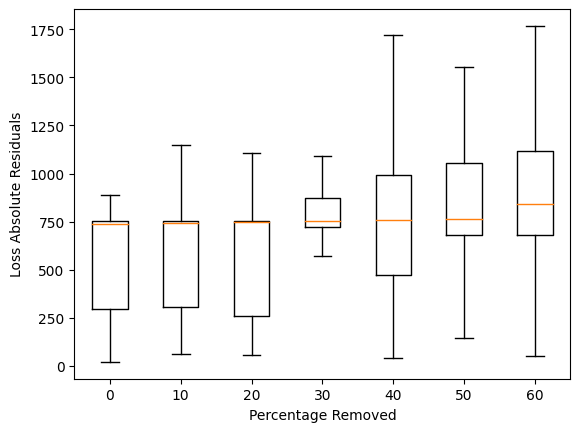

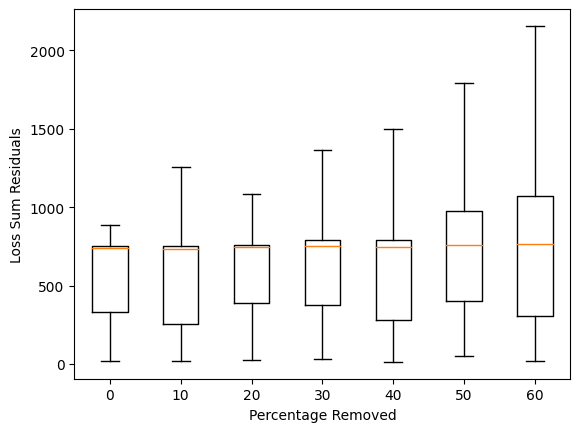

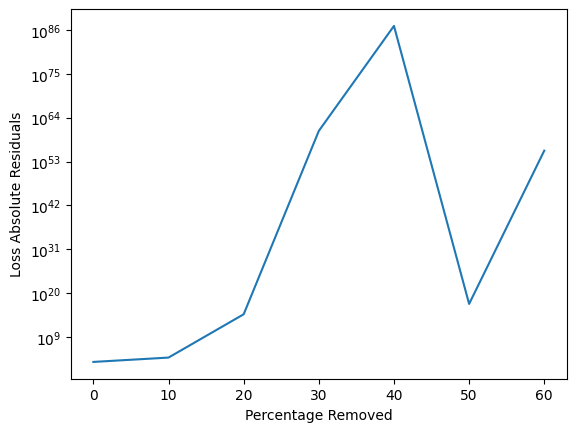

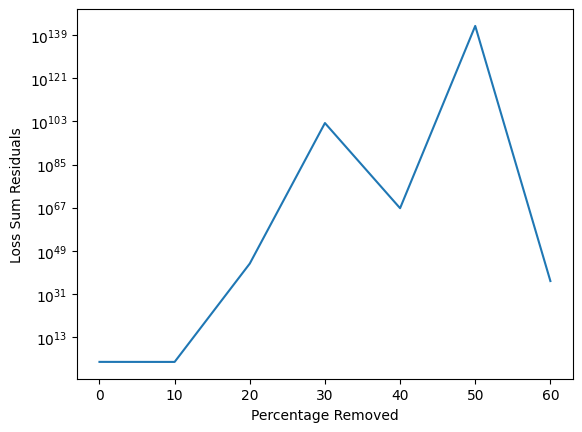

           Method        Optimization          Mean   Lower Bound  \
0   Remove Random  Absolute Residuals  5.614659e+02  5.083476e+02   
10  Remove Random  Absolute Residuals  6.899078e+03 -5.605655e+03   
20  Remove Random  Absolute Residuals  5.009850e+14 -4.930779e+14   
30  Remove Random  Absolute Residuals  4.966903e+60 -4.888510e+60   
40  Remove Random  Absolute Residuals  1.075318e+87 -1.058346e+87   
50  Remove Random  Absolute Residuals  1.998255e+17 -1.359881e+17   
60  Remove Random  Absolute Residuals  5.607831e+55 -5.519323e+55   

     Upper Bound  
0   6.145843e+02  
10  1.940381e+04  
20  1.495048e+15  
30  1.482232e+61  
40  3.208982e+87  
50  5.356392e+17  
60  1.673499e+56  
           Method   Optimization           Mean    Lower Bound    Upper Bound
0   Remove Random  Sum Residuals   5.901280e+02   5.386567e+02   6.415993e+02
10  Remove Random  Sum Residuals   5.696045e+02   5.053610e+02   6.338480e+02
20  Remove Random  Sum Residuals   5.647441e+43  -5.341770e+4

In [86]:
a = 'Absolute Residuals'
s = 'Sum Residuals'
r = 'Remove Random'

plot_box_dict(dict_abs, a)
plot_box_dict(dict_sum, s)
df_abs = plot_dict(dict_abs, a, r)
df_sum = plot_dict(dict_sum, s, r)

print(df_abs)
print(df_sum)

In [96]:
c = 'Combine'

# mean = np.mean(dict_abs_combine)
# ci =stat.t.interval(confidence=0.95, df=len(dict_abs_combine)-1, loc=mean, scale=stat.sem(dict_abs_combine))
# lower = ci[0]
# upper = ci[1]
# data1 = {'Method': c, 'Optimization': a, 'Mean': mean, 'Lower Bound': lower, 'Upper Bound': upper}
# df_abs_combine = pd.DataFrame(data1, columns=['Method','Optimization', 'Mean', 'Lower Bound', 'Upper Bound'], index=['40+60'])

# mean = np.mean(dict_sum_combine)
# ci =stat.t.interval(confidence=0.95, df=len(dict_sum_combine)-1, loc=mean, scale=stat.sem(dict_sum_combine))
# lower = ci[0]
# upper = ci[1]
# data2 = {'Method':c, 'Optimization': s, 'Mean': mean, 'Lower Bound': lower, 'Upper Bound': upper}
# df_sum_combine = pd.DataFrame(data2, columns=['Method','Optimization', 'Mean', 'Lower Bound', 'Upper Bound'], index=['40+60'])

# print(df_abs_combine)
# print(df_sum_combine)

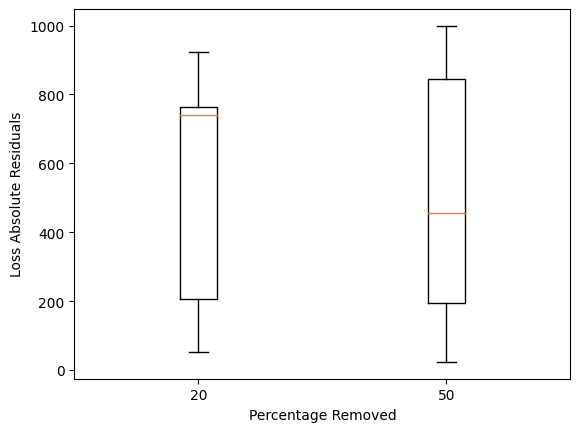

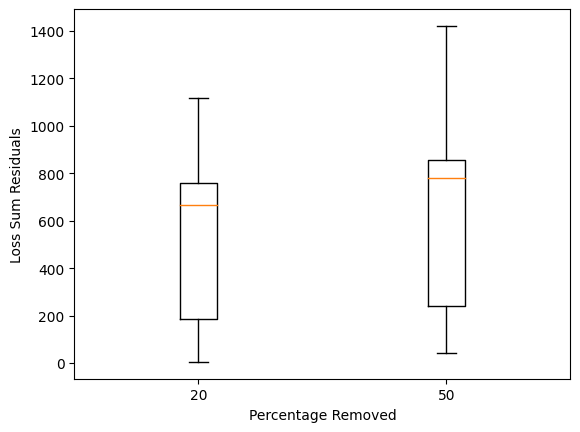

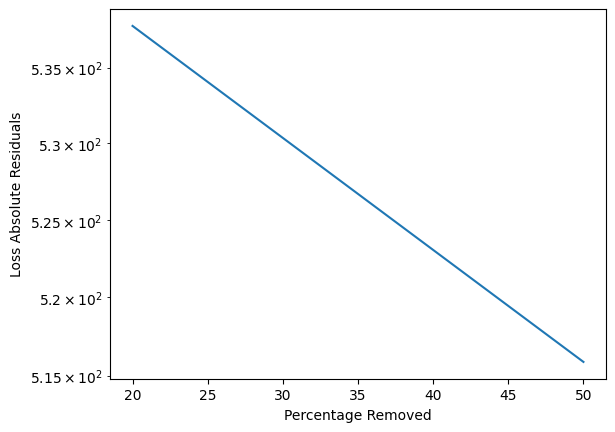

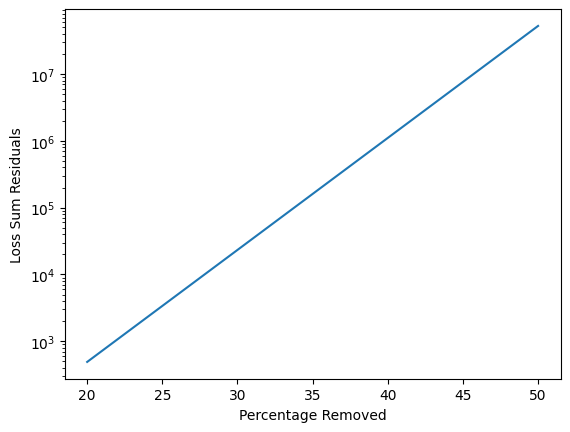

         Method        Optimization        Mean  Lower Bound  Upper Bound
20  Remove Last  Absolute Residuals  537.761439   472.156249   603.366628
50  Remove Last  Absolute Residuals  515.870006   444.596148   587.143865
         Method   Optimization          Mean   Lower Bound   Upper Bound
20  Remove Last  Sum Residuals  4.903570e+02  4.308538e+02  5.498602e+02
50  Remove Last  Sum Residuals  5.252069e+07 -5.168925e+07  1.567306e+08


In [25]:
l = "Remove Last"
plot_box_dict(dict_abs_specific, a)
plot_box_dict(dict_sum_specific, s)
df_abs_specific = plot_dict(dict_abs_specific, a, l)
df_sum_specific = plot_dict(dict_sum_specific, s, l)

print(df_abs_specific)
print(df_sum_specific)

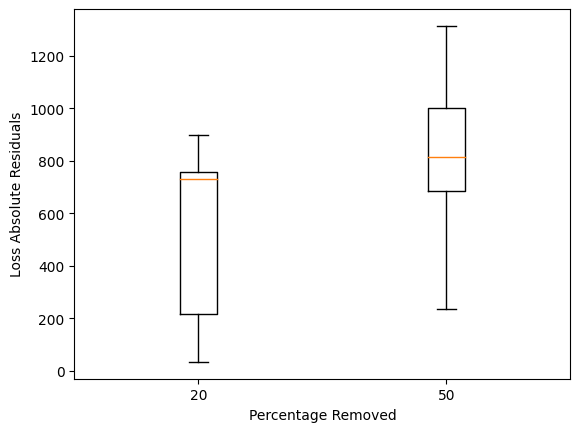

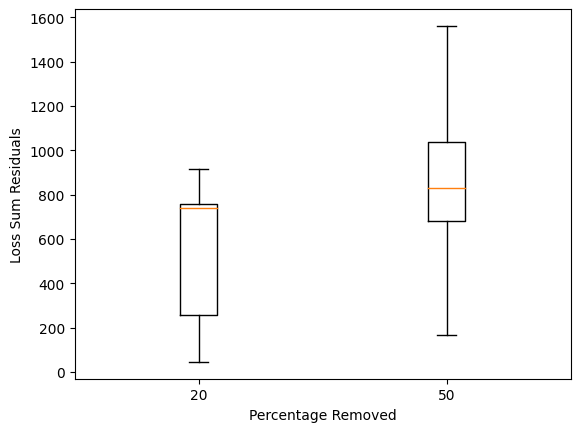

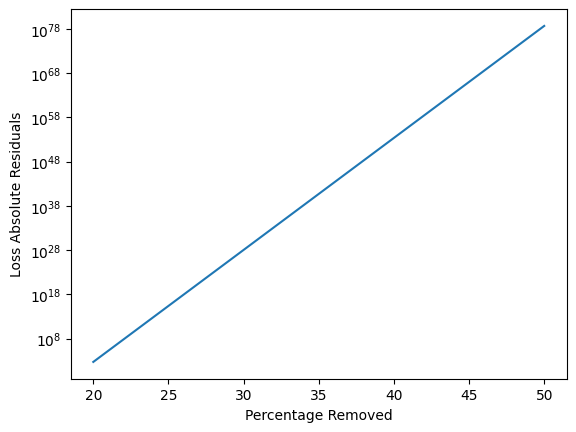

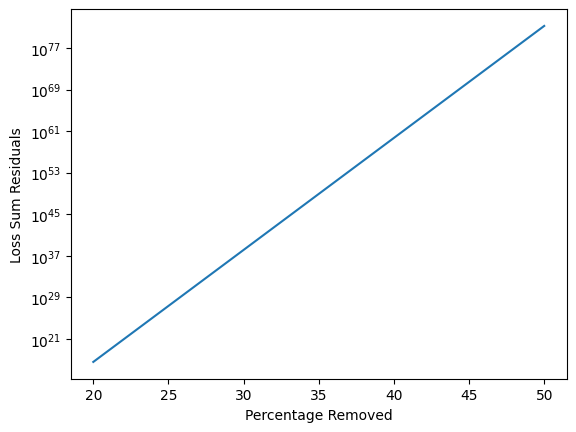

In [26]:
p = 'Peaks Predator'
plot_box_dict(dict_abs_peaks,a)
plot_box_dict(dict_sum_peaks,s)
df_abs_peaks = plot_dict(dict_abs_peaks,a, p)
df_sum_peaks = plot_dict(dict_sum_peaks,s, p)

In [91]:
# df_losses = pd.concat([df_abs,df_sum,df_abs_combine,df_sum_combine,df_abs_specific,df_sum_specific,df_abs_peaks ,df_sum_peaks ], ignore_index=False)
# df_losses.to_csv('timeseries_ci.csv')

### Statistical Tests

In [92]:
# dict_abs
# dict_sum
list_abs_combine = [692.584575794109,
 68.1418395240675,
 146.42302623128361,
 138.28985765539403,
 744.5096571927884,
 252.5362669539149,
 794.3176536333037,
 753.054850292975,
 759.9508785405942,
 471.9727286000342,
 82.75254875795422,
 184.36231721479433,
 733.8414355289435,
 741.4465753406826,
 753.5512116938119,
 3.669614500929367e+16,
 301.68819997018454,
 743.6555882967856,
 743.3611605951646,
 401.0878629572017,
 786.651884533177,
 216.06059047958976,
 1027.1245590677486,
 1658.2742886097874,
 929.6858079097758,
 6.989548680936379e+151,
 167.7309573140569,
 745.3650482010282,
 754.7591509227292,
 766.3232587649981,
 246.62782961260112,
 1585.8208298585228,
 756.595044726009,
 93.92345823785877,
 754.152690757534,
 149.32511947807063,
 163.42394909011009,
 750.0255058565333,
 723.5034996892165,
 768.9979993356668,
 152.49069382151725,
 736.9051400171793,
 1362.9651725475921,
 105.4696240433879,
 750.3890620883784,
 197.42341440106736,
 711.4709723166981,
 238.67670290581887,
 1050.3275536144306,
 314.5082981935572,
 747.2356466375003,
 272.51385371403234,
 215.09175931724926,
 621.2475682226406,
 343.4598040692798,
 139.12351129707966,
 742.638811908864,
 166.33791481680663,
 139.27397821560882,
 780.6241418233476,
 266.7869936935682,
 753.1984293272327,
 757.7193690361189,
 38.57057422105619,
 341.53692946613313,
 763.8178248775037,
 760.0454963674193,
 760.6059626163765,
 171.0612056279138,
 157.73672101718287,
 704.5619402899536,
 586.6824876483836,
 754.4150619928455,
 752.6589303826786,
 188.02446209125742,
 884.4301506439099,
 725.0293899958738,
 823.4850259573108,
 755.1080338231905,
 657.5475760209335,
 778.0269584301682,
 762.1248601386127,
 755.3935344101179,
 750.3083850678488,
 86.76851534467913,
 751.0828019145483,
 232.0800490792483,
 883.8383132216644,
 380.9964110261664,
 718.3291158046171,
 756.3845707405344,
 1.5508500985389843e+17,
 202.55453509138775,
 774.7835339175427,
 745.5513866917977,
 748.1015678838953,
 90.14929736098357,
 757.0334465718149,
 77.95074363013538,
 768.8526770820555]
list_sum_combine = [734.1741905050108,
 971.6072090039678,
 900.6786418576321,
 792.2737567824626,
 99.91643612182041,
 26747597.3790165,
 209.98633593245745,
 1088.8442086371367,
 687.4075042970326,
 755.1097205205368,
 639.0580428666568,
 799.7385480379552,
 735.8696980110724,
 748.9402811180009,
 199.2915677137065,
 731.4727300478016,
 750.4723993120442,
 756.0639489475184,
 668.0455793392422,
 1058.093318535606,
 767.8855040870063,
 195.07797820124188,
 776.8186360240643,
 28.409284873925905,
 194.80702374900392,
 749.9434696127354,
 252.93994955354412,
 750.0330347538194,
 885.9088342048018,
 741.4856953038014,
 736.1694077392007,
 749.5130486733415,
 1091.339202938288,
 254.20350922351034,
 878.3980874032706,
 752.6009740953285,
 831.4807319592211,
 788.6540982158135,
 752.5238779129094,
 591.830749391971,
 229.4133024628477,
 707.1543845386956,
 748.5794241785769,
 752.0538200774555,
 756.0491393579264,
 382.48696327154926,
 676.9611981686961,
 274.08683409249255,
 24.5958463724006,
 152.1271071300761,
 752.8740600939877,
 103.50496972717664,
 196.04021861025493,
 874.5549027158949,
 735.0646199943949,
 112.99622301359571,
 345.4989573440447,
 751.17640680243,
 3382.6529023923363,
 880.8985920845796,
 136.17554865775347,
 128.43755976814077,
 882.9918508790455,
 743.2269926967546,
 346.8427798234635,
 744.5564706277473,
 334.55464612896475,
 106.92798979211732,
 753.0042445438119,
 927.2509956494375,
 9818871587386.463,
 289.56821227148123,
 752.4291297930437,
 1191.680809376029,
 2681.41062416362,
 751.2971472243481,
 865.0901848186085,
 750.8720294713474,
 287.5125944602399,
 943.4348020902411,
 222.97517328867448,
 695.6503054786591,
 707.2374781556058,
 757.7091554125199,
 199.45754779003852,
 658.1720118340563,
 756.7508635850136,
 113.86933428571437,
 751.3691736716117,
 875.9107531587297,
 752.2726332505944,
 95.37424899605791,
 1.158401271936356e+41,
 766.3989800567957,
 747.6174268695574,
 765.9059351978259,
 872.0246774087233,
 197.6209026318638,
 91.92734359391329,
 2258.5571406643157]
# dict_abs_specific
# dict_sum_specific
# dict_abs_peaks 
# dict_sum_peaks



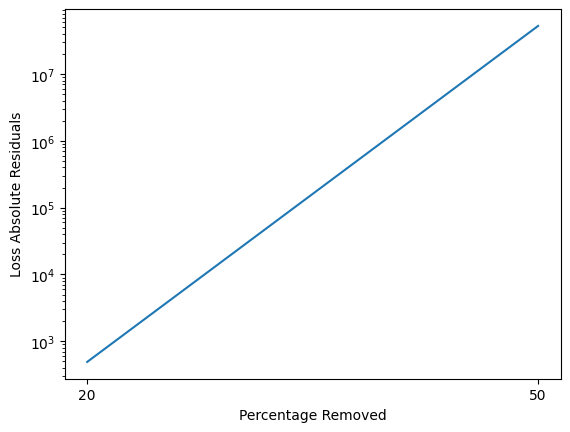

,Method,Optimization,Mean,Lower Bound,Upper Bound
20,Remove Random,Absolute Residuals,4.903570e+02,4.308538e+02,5.498602e+02
50,Remove Random,Absolute Residuals,5.252069e+07,-5.168925e+07,1.567306e+08


In [95]:
plot_dict(open_dict('dict_sum_specific.csv'), a, r)